In [1]:
import os
import csv
import zipfile
import string
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
qol_data = pd.read_csv("D:/qol_beat.csv")
crime_data = pd.read_csv("D:/crime_beat.csv")

In [5]:
# only analysis 70117 & 70119 zipcode area
crime_data = crime_data[crime_data.Zip != 70130]
qol_data = qol_data[qol_data.zip_code != 70130]

## 1. Data overview

### (1) Crimes distributions among beats

In [6]:
# top 4 beats with highest crimes in two areas
a = crime_data['Beat'].groupby(crime_data['Zip']).value_counts()
a.groupby(level=0).nlargest(4)

Zip    Zip    Beat
70117  70117  5G02    79
              8F04    73
              5G01    59
              5E01    58
70119  70119  5K02    80
              1I03    60
              1K01    50
              1C02    47
Name: Beat, dtype: int64

In [271]:
s = a.groupby(level=0).nlargest(5)
idx = list(s.index)
beat_list = []
for ele in idx:
    beat_list.append(ele[2])
beat_list

['5G02',
 '8F04',
 '5G01',
 '5E01',
 '5C02',
 '5K02',
 '1I03',
 '1K01',
 '1C02',
 '5K01']

### (2) Life of indicator distributions

In [4]:
# get top 15 frequent life of indicators
qol_data.issue_type.value_counts()[0:15]

Code Enforcement General Request       5153
Trash/Garbage Pickup                   4531
Abandoned Vehicle Reporting/Removal    4074
Residential Recycling Programs         3680
Street Light                           2901
Large Item Trash/Garbage Pickup        2616
Illegal Dumping Reporting              2042
Pothole/Roadway Surface Repair          925
Rodent Complaint                        666
Street Flooding/Drainage                617
Tree Service                            594
Traffic Sign                            397
Tree Service Emergency                  352
Mosquito Control                        349
Catch Basin Maintenance                 280
Name: issue_type, dtype: int64

## 2. Data processing

### (1) Data processing functions

In [7]:
# delet hours, minutes, and seconds, getting new clean dates
def getDate(data, col):
    date = pd.to_datetime(data[col])
    year = date.dt.year
    month = date.dt.month
    day = date.dt.day
    Newdate = pd.to_datetime(year*10000 + month*100 + day, format='%Y%m%d')
    return Newdate

In [8]:
# select data for a particular beat and a particular issue
def getDataFrame(crime, qol, beat, issue):
    crime_beat = crime[crime["Beat"] == beat]
    qol_beat = qol[(qol["Beat"] == beat) & (qol["issue_type"] == issue)]
    
    start = getDate(qol_beat, "start")
    end = getDate(qol_beat, "end")
    date = getDate(crime_beat, "Date")
    
    qol_date = pd.DataFrame({'StartDate': start,
                             'EndDate': end,
                            }, index = None)
    
    crime_count = pd.DataFrame({'Number': np.repeat(1, len(date))
                               }, index = date)

    return (qol_date, crime_count)

In [9]:
# get number of crimes happended in a particular time windows 
# time windows are defined by features startDate and endDate of the quality of life indicators
def aggregateDateByTimeWin(indicator, crime, startDate, endDate):
    before = []
    during = []
    after = []
    for i in range(len(indicator)):
        duration = (indicator[endDate].iloc[i] - indicator[startDate].iloc[i]).days
        lastStart = crime.index.searchsorted(indicator[startDate].iloc[i] - dt.timedelta(days= duration))
        lastEnd = crime.index.searchsorted(indicator[startDate].iloc[i])
        currStart = crime.index.searchsorted(indicator[startDate].iloc[i])
        currEnd = crime.index.searchsorted(indicator[endDate].iloc[i])
        nextStart = crime.index.searchsorted(indicator[endDate].iloc[i])
        nextEnd = crime.index.searchsorted(indicator[endDate].iloc[i] + dt.timedelta(days = duration))
        beforeNum = before.append(int(sum(crime.ix[lastStart:lastStart].values)))
        duringNum = during.append(int(sum(crime.ix[currStart:currEnd].values)))
        afterNum = after.append(int(sum(crime.ix[nextStart:nextEnd].values)))
    
    
    count_table = pd.DataFrame({'Time': ["Before"] * len(before) + ["During"] * len(during) + ["After"] * len(after),
                                'Num_Crimes': before + during + after,
                                }, index = None)
        
    return count_table
    # return [before, during, after]

In [10]:
# get the final function, completing it once
def getAggCountTable(crime, qol, beat, issue):
    qol_date, crime_count = getDataFrame(crime, qol, beat, issue)
    count_tb = aggregateDateByTimeWin(qol_date, crime_count, "StartDate", "EndDate")
    return count_tb

## 3. Life of quality indicators analysis

In [46]:
# select top 4 beats for each zipcode and top 12 QOL according to their frequencies
beat_list = ["5G02", "8F04", "5G01", "5E01", "5K02", "1I03", "1C02", "1K01"]
issue_list = list(qol_data.issue_type.value_counts().index[0:125])

### (1) Code Enforcement General Request

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


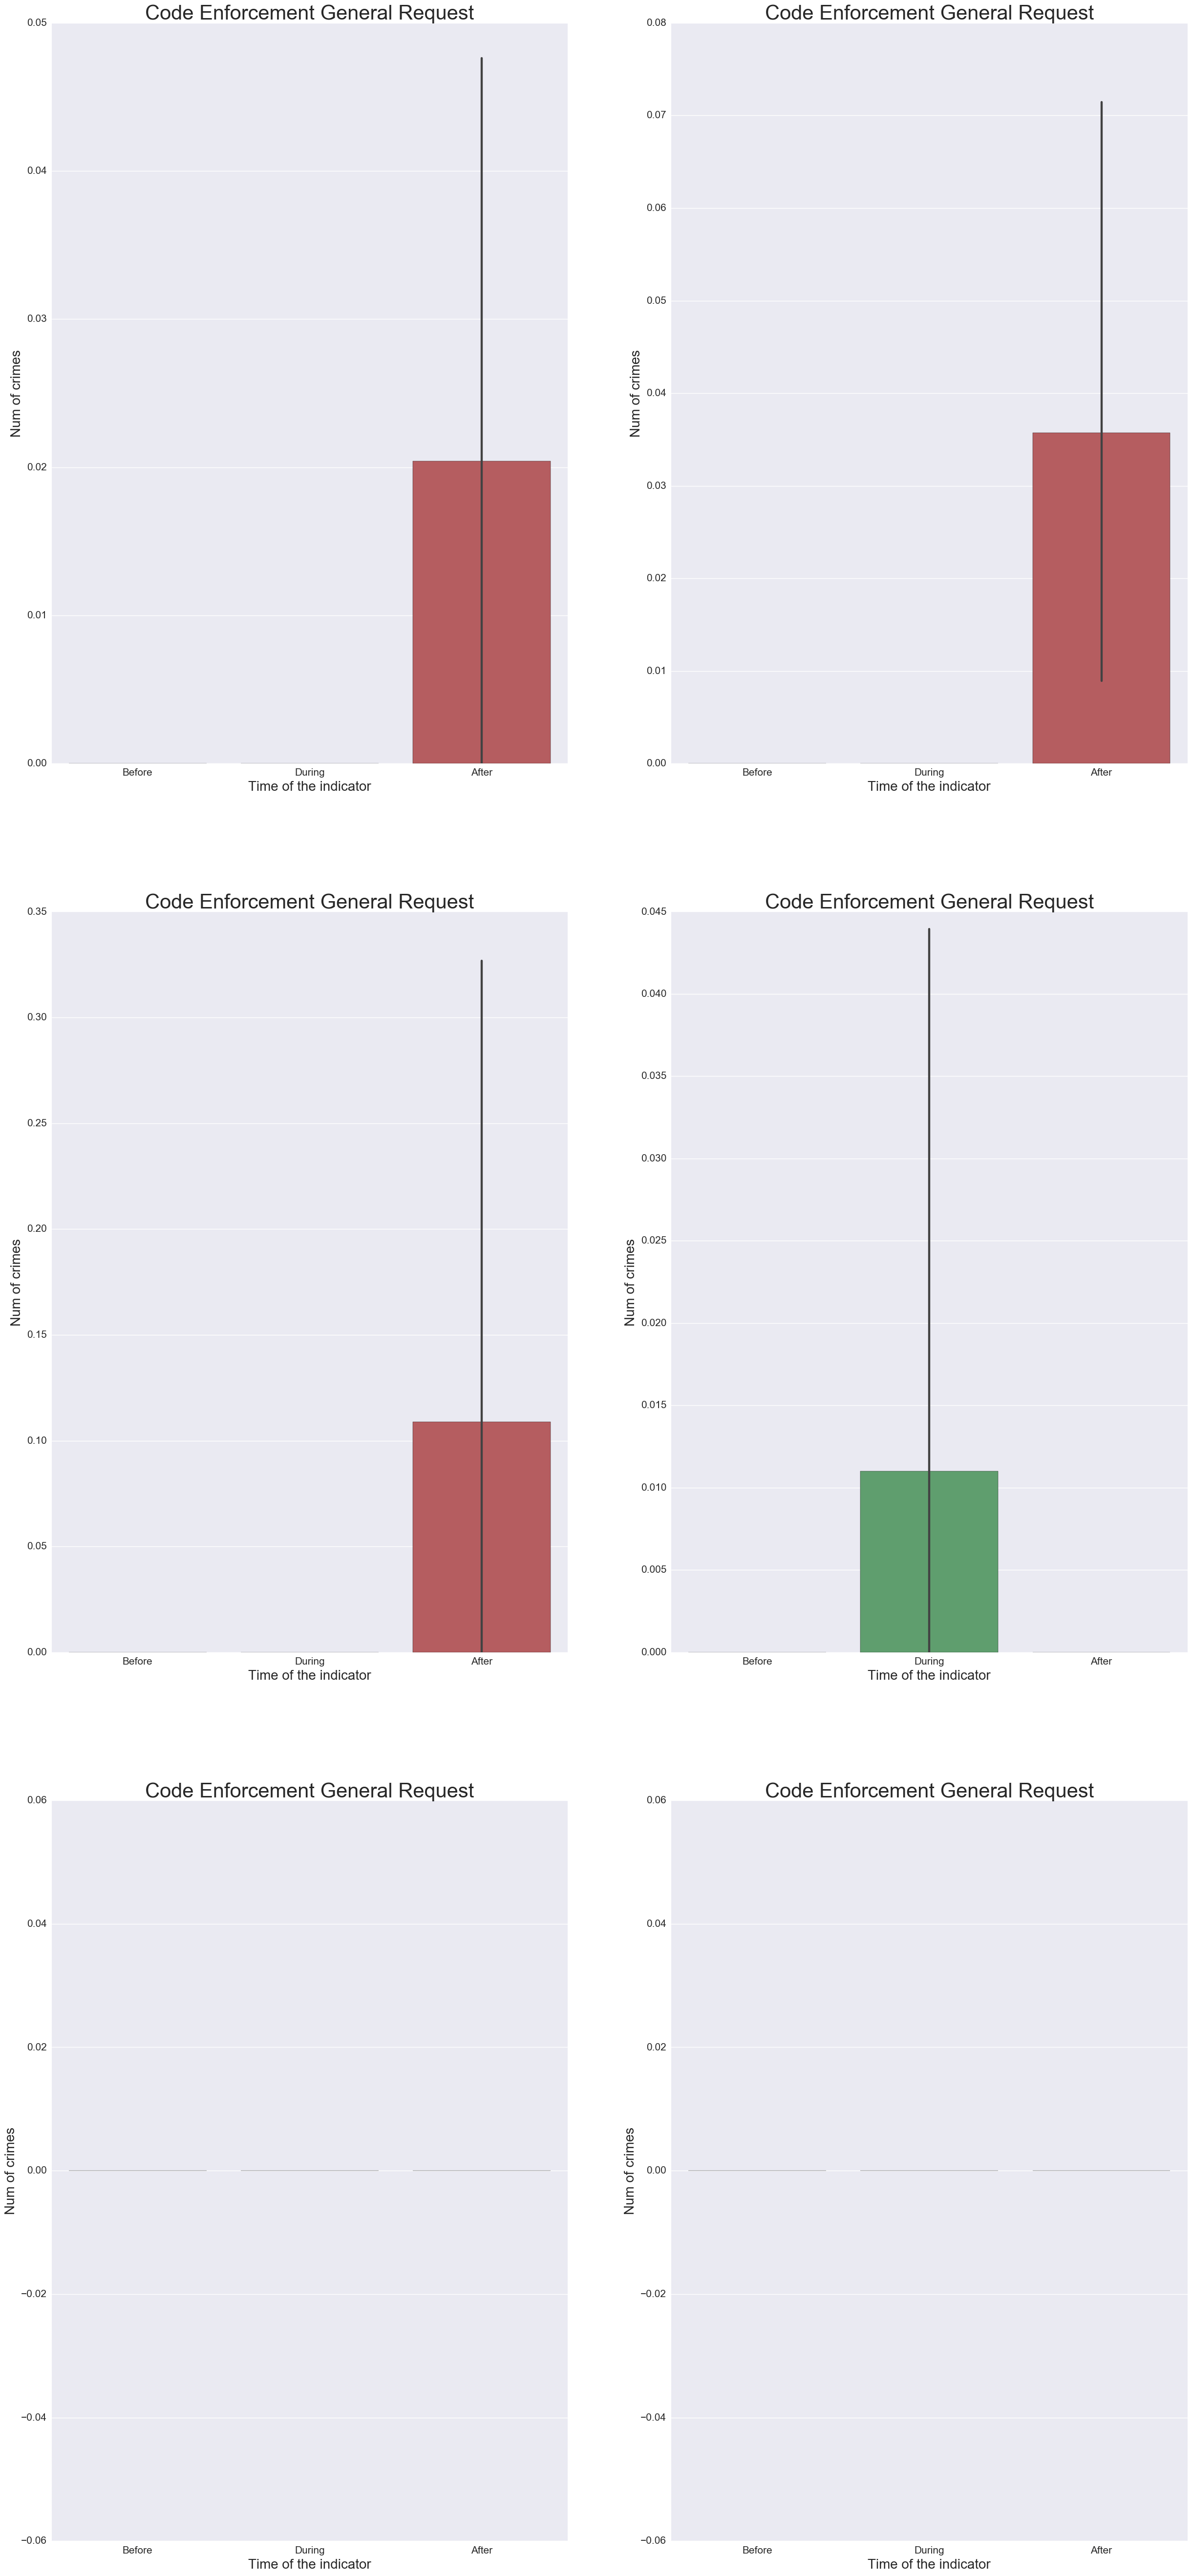

In [20]:
beat_list1 = ["5G02", "5G01", "5K02", "1I03", "1K01", "1C02"]
# no record for 8F04 & 5E01 

fig = plt.figure(dpi = 150, figsize = (30, 90))

for i in range(len(beat_list1)):
    tb = getAggCountTable(crime_data, qol_data, beat_list1[i], issue_list[0])
    ax1 = fig.add_subplot(4, 2, i + 1)
    ax1.plot =sns.barplot(x = "Time", y = "Num_Crimes", data = tb)
    plt.title(beat_list[i], fontsize = 40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(issue_list[0], fontsize = 30)
    plt.xlabel("Time of the indicator", fontsize = 20)
    plt.ylabel("Num of crimes", fontsize = 20)

fig.show()

### (2) Trash/Garbage Pickup

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


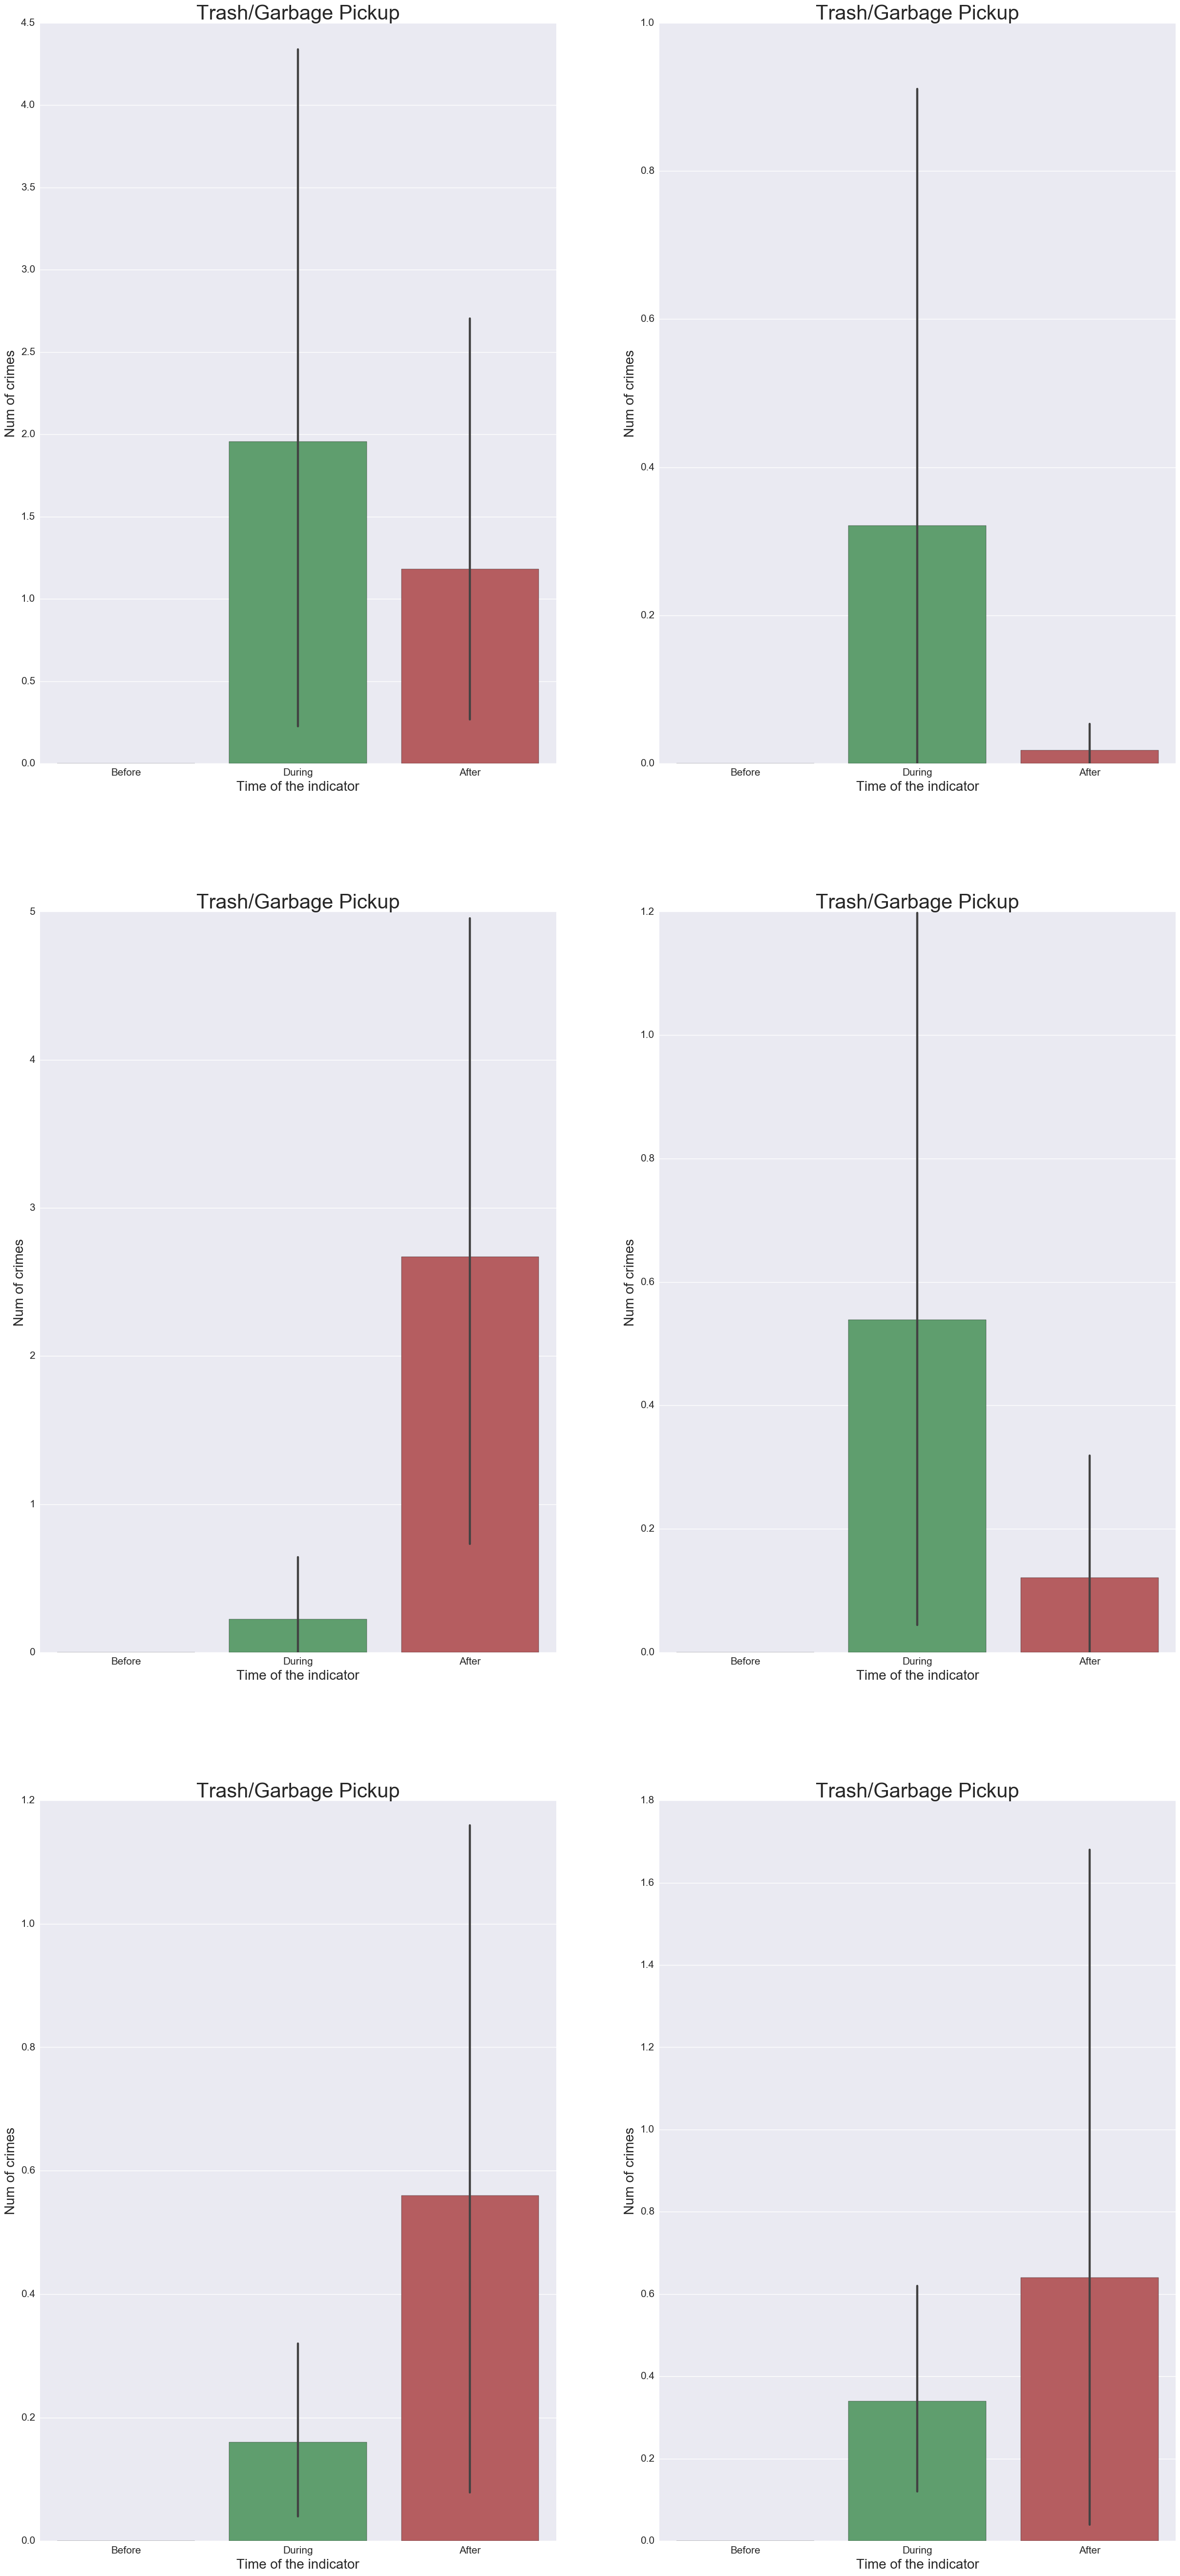

In [25]:
fig = plt.figure(dpi = 150, figsize = (30, 90))

for i in range(len(beat_list1)):
    tb = getAggCountTable(crime_data, qol_data, beat_list1[i], issue_list[1])
    ax1 = fig.add_subplot(4, 2, i + 1)
    ax1.plot =sns.barplot(x = "Time", y = "Num_Crimes", data = tb)
    plt.title(beat_list[i], fontsize = 40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(issue_list[1], fontsize = 30)
    plt.xlabel("Time of the indicator", fontsize = 20)
    plt.ylabel("Num of crimes", fontsize = 20)

fig.show()

### (3) Abandoned Vehicle Reporting/Removal

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


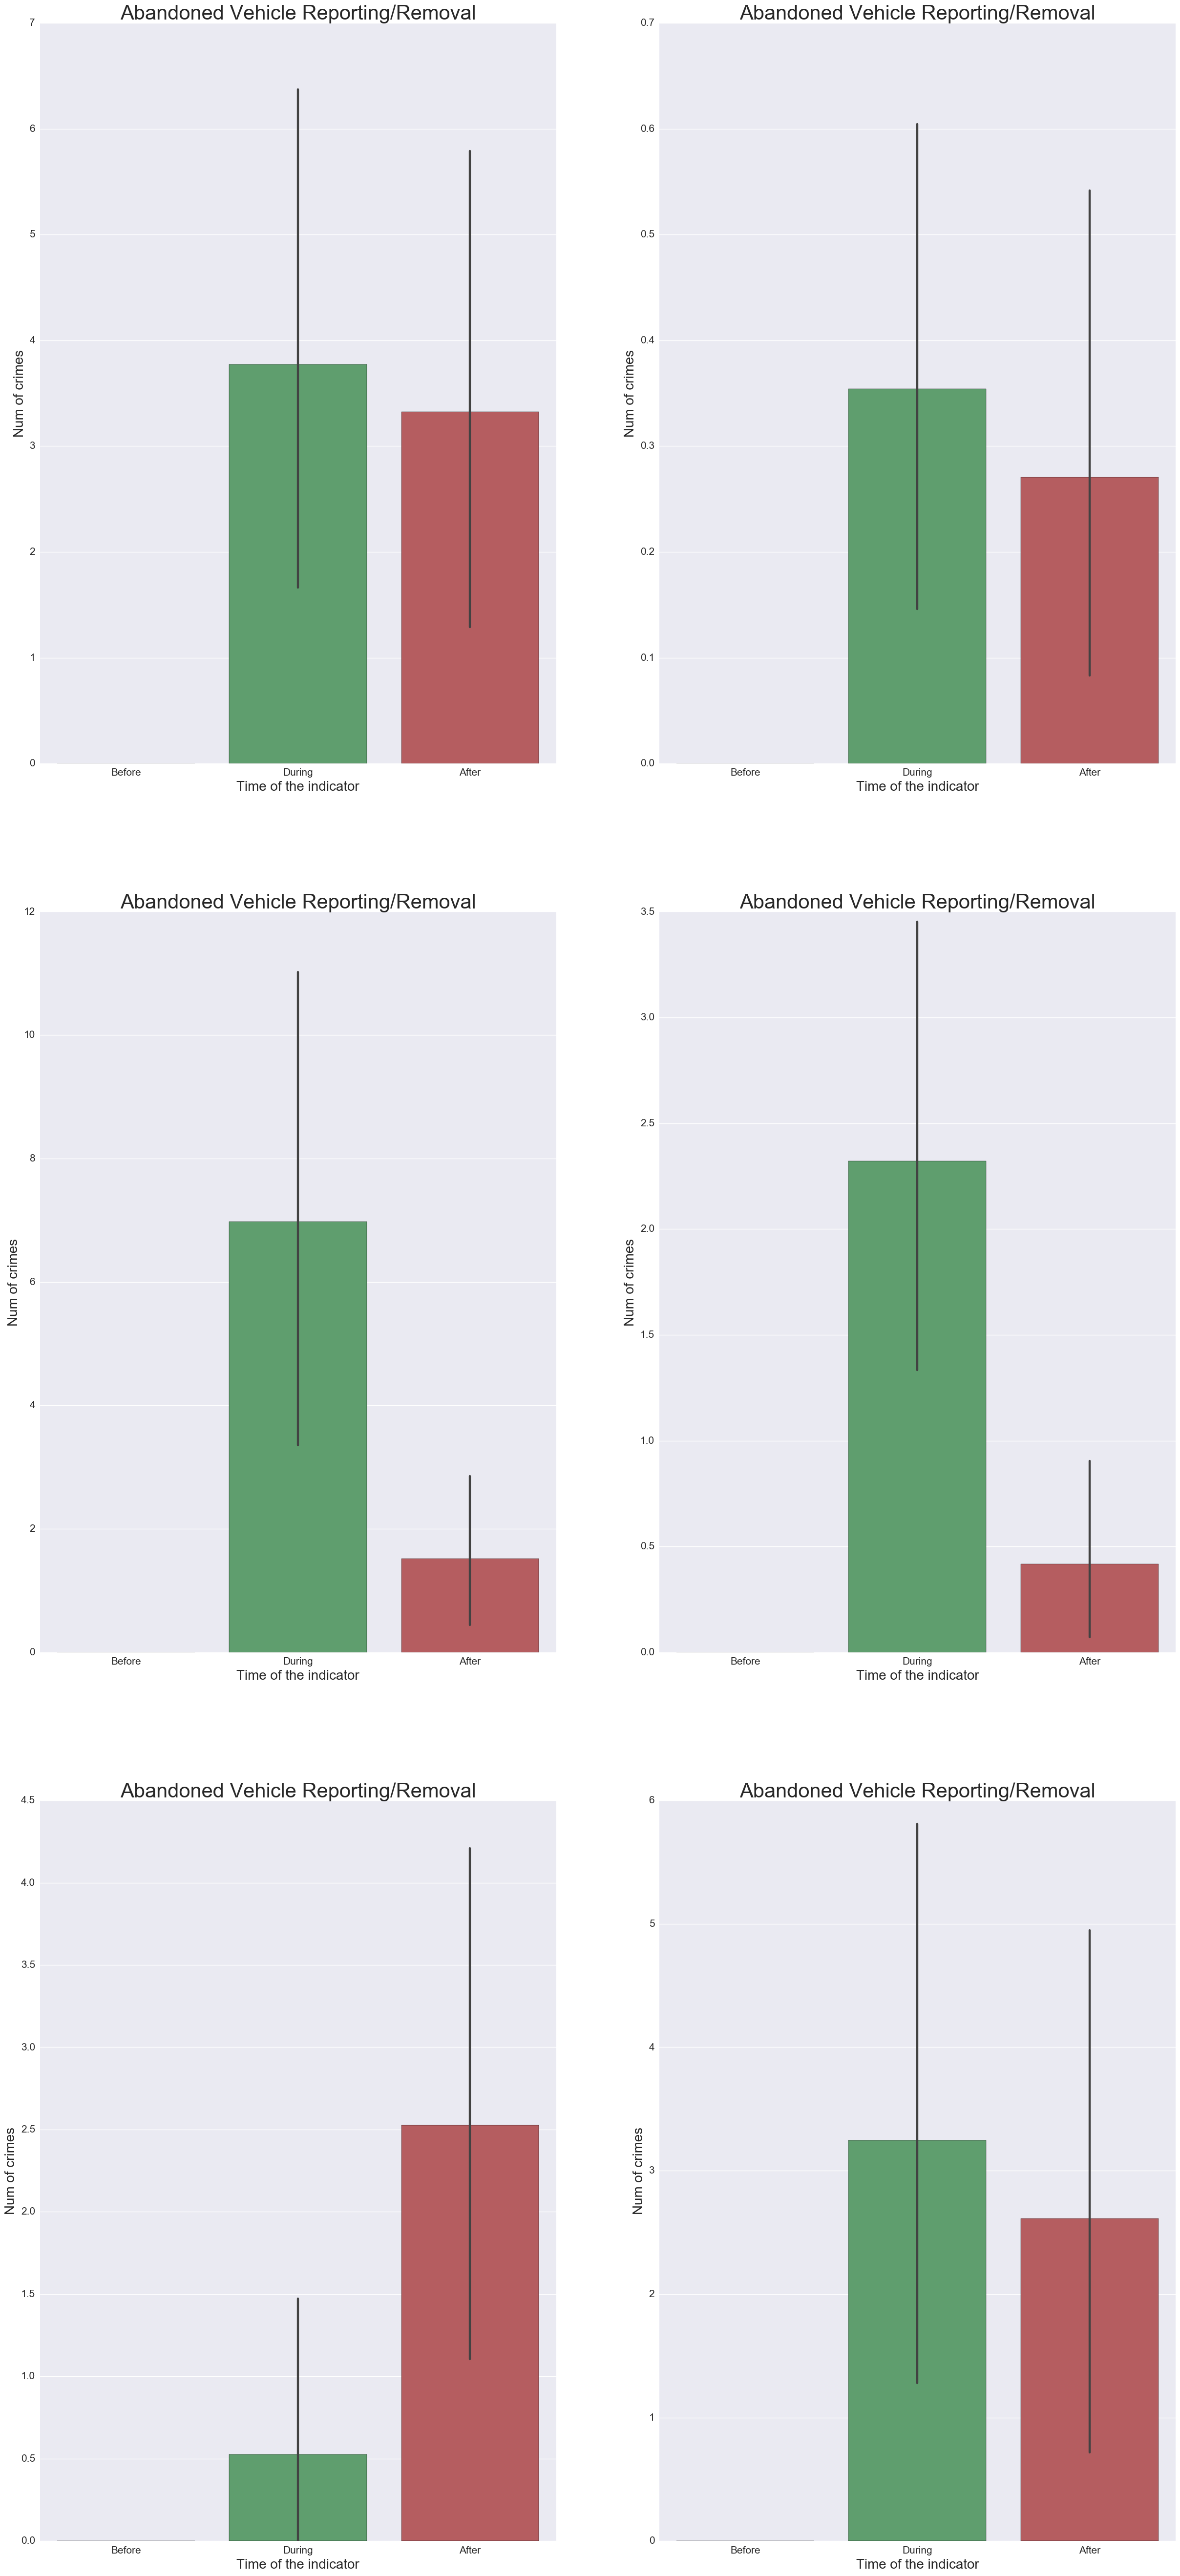

In [27]:
fig = plt.figure(dpi = 150, figsize = (30, 90))

for i in range(len(beat_list1)):
    tb = getAggCountTable(crime_data, qol_data, beat_list1[i], issue_list[2])
    ax1 = fig.add_subplot(4, 2, i + 1)
    ax1.plot =sns.barplot(x = "Time", y = "Num_Crimes", data = tb)
    plt.title(beat_list[i], fontsize = 40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(issue_list[2], fontsize = 30)
    plt.xlabel("Time of the indicator", fontsize = 20)
    plt.ylabel("Num of crimes", fontsize = 20)

fig.show()

### (4) Residential Recycling Programs

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


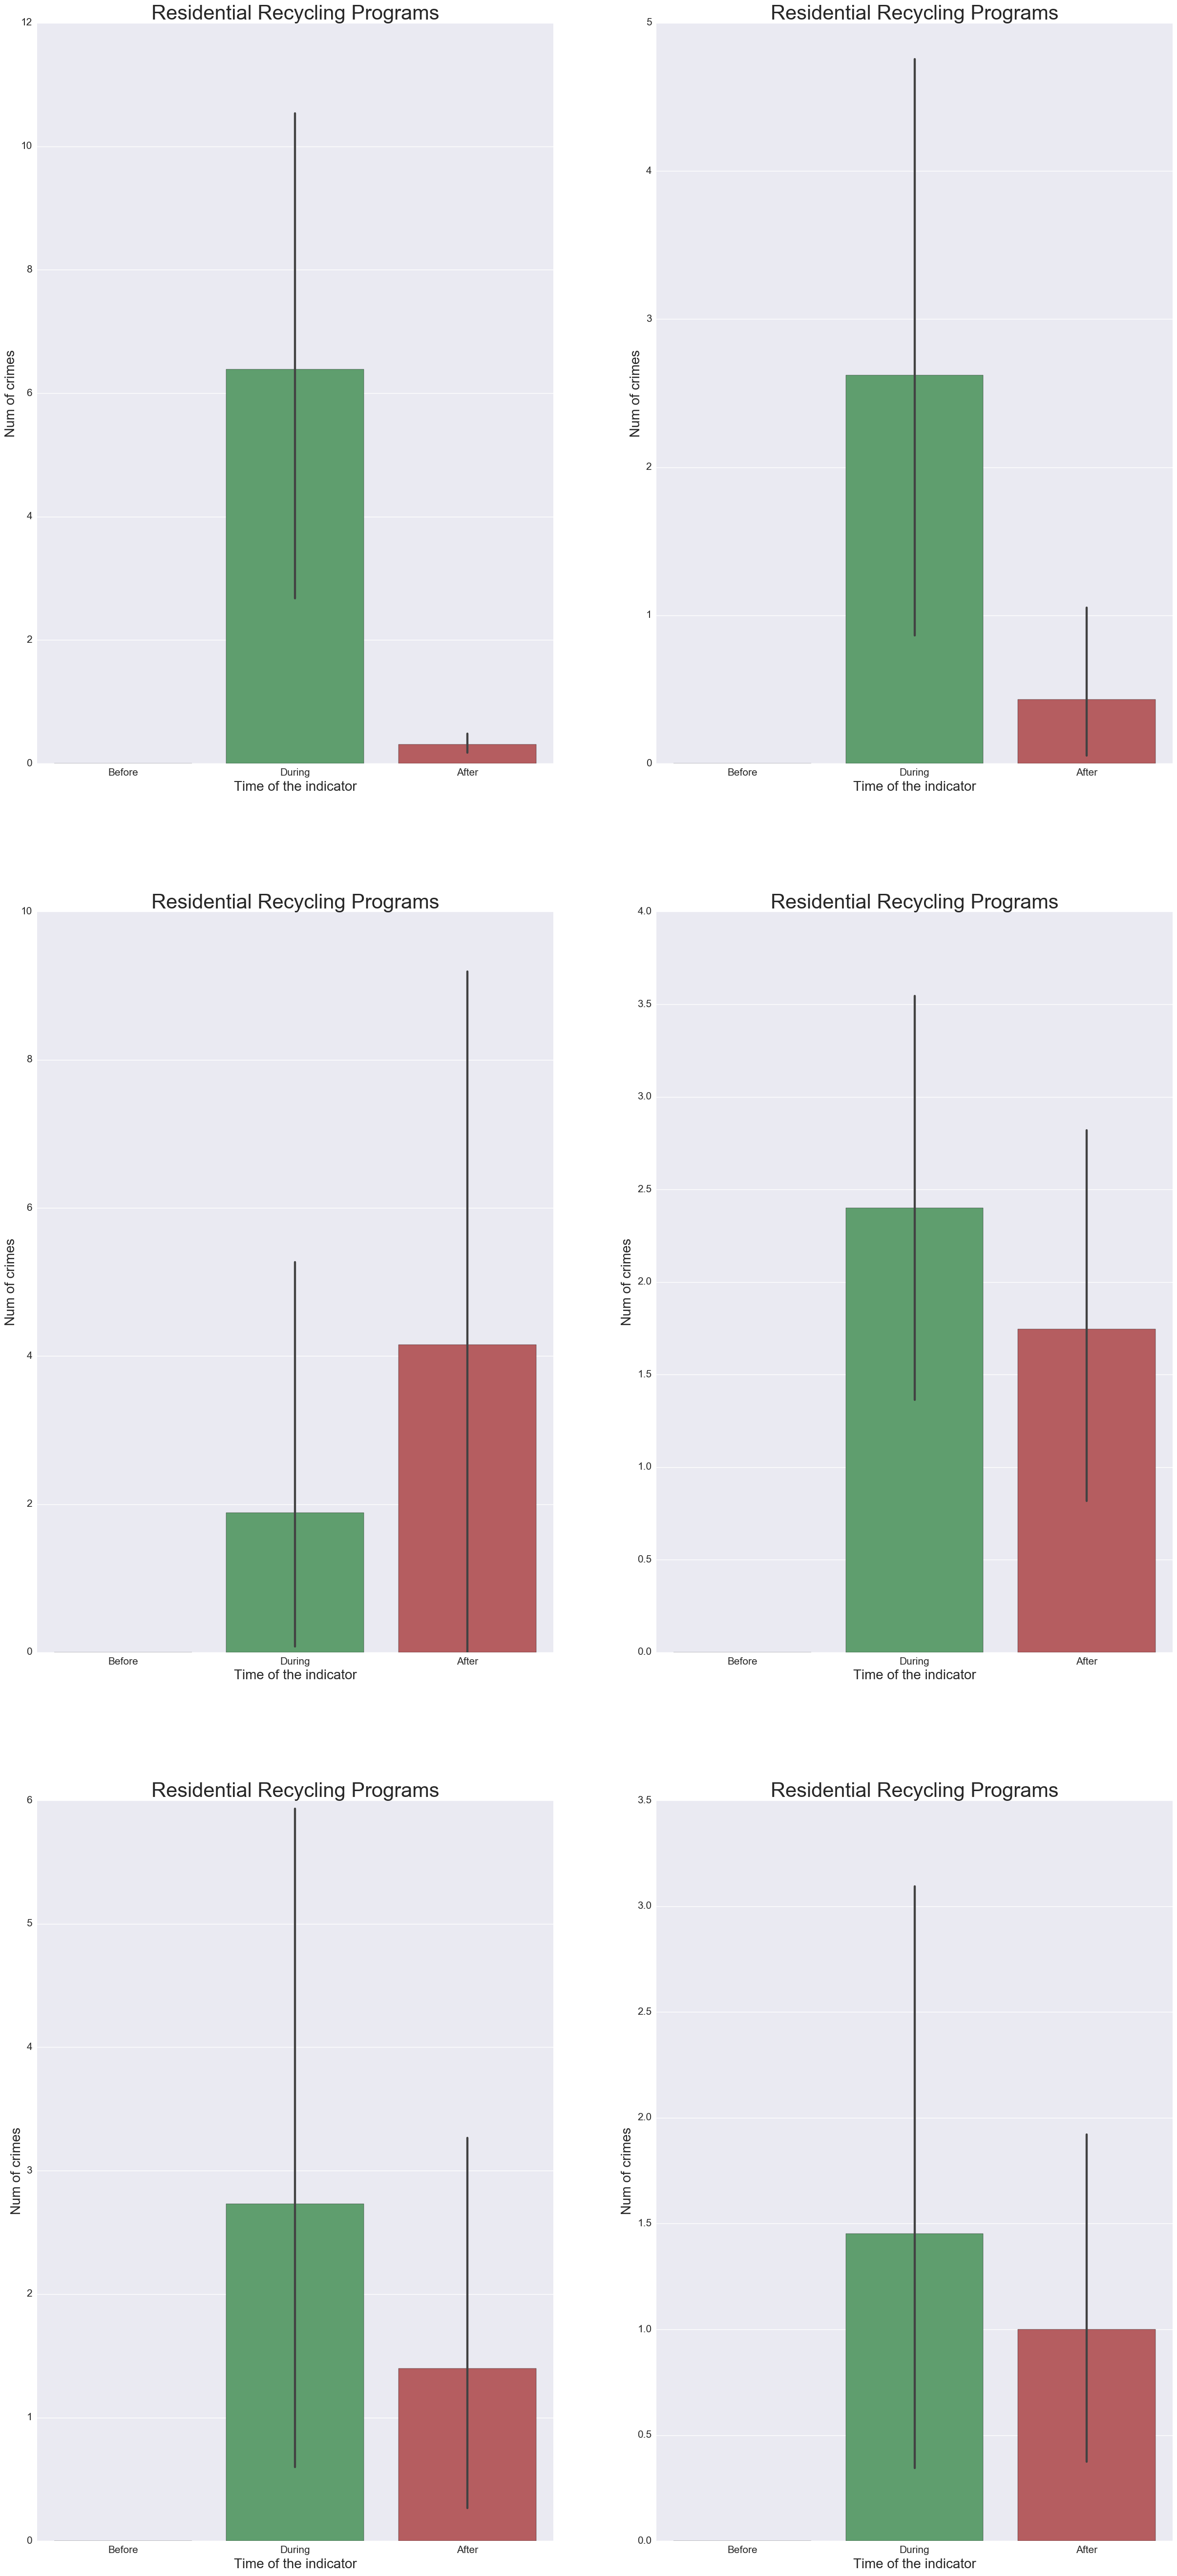

In [29]:
fig = plt.figure(dpi = 150, figsize = (30, 90))

for i in range(len(beat_list1)):
    tb = getAggCountTable(crime_data, qol_data, beat_list1[i], issue_list[3])
    ax1 = fig.add_subplot(4, 2, i + 1)
    ax1.plot =sns.barplot(x = "Time", y = "Num_Crimes", data = tb)
    plt.title(beat_list[i], fontsize = 40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(issue_list[3], fontsize = 30)
    plt.xlabel("Time of the indicator", fontsize = 20)
    plt.ylabel("Num of crimes", fontsize = 20)

fig.show()

### (5) Street Light

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


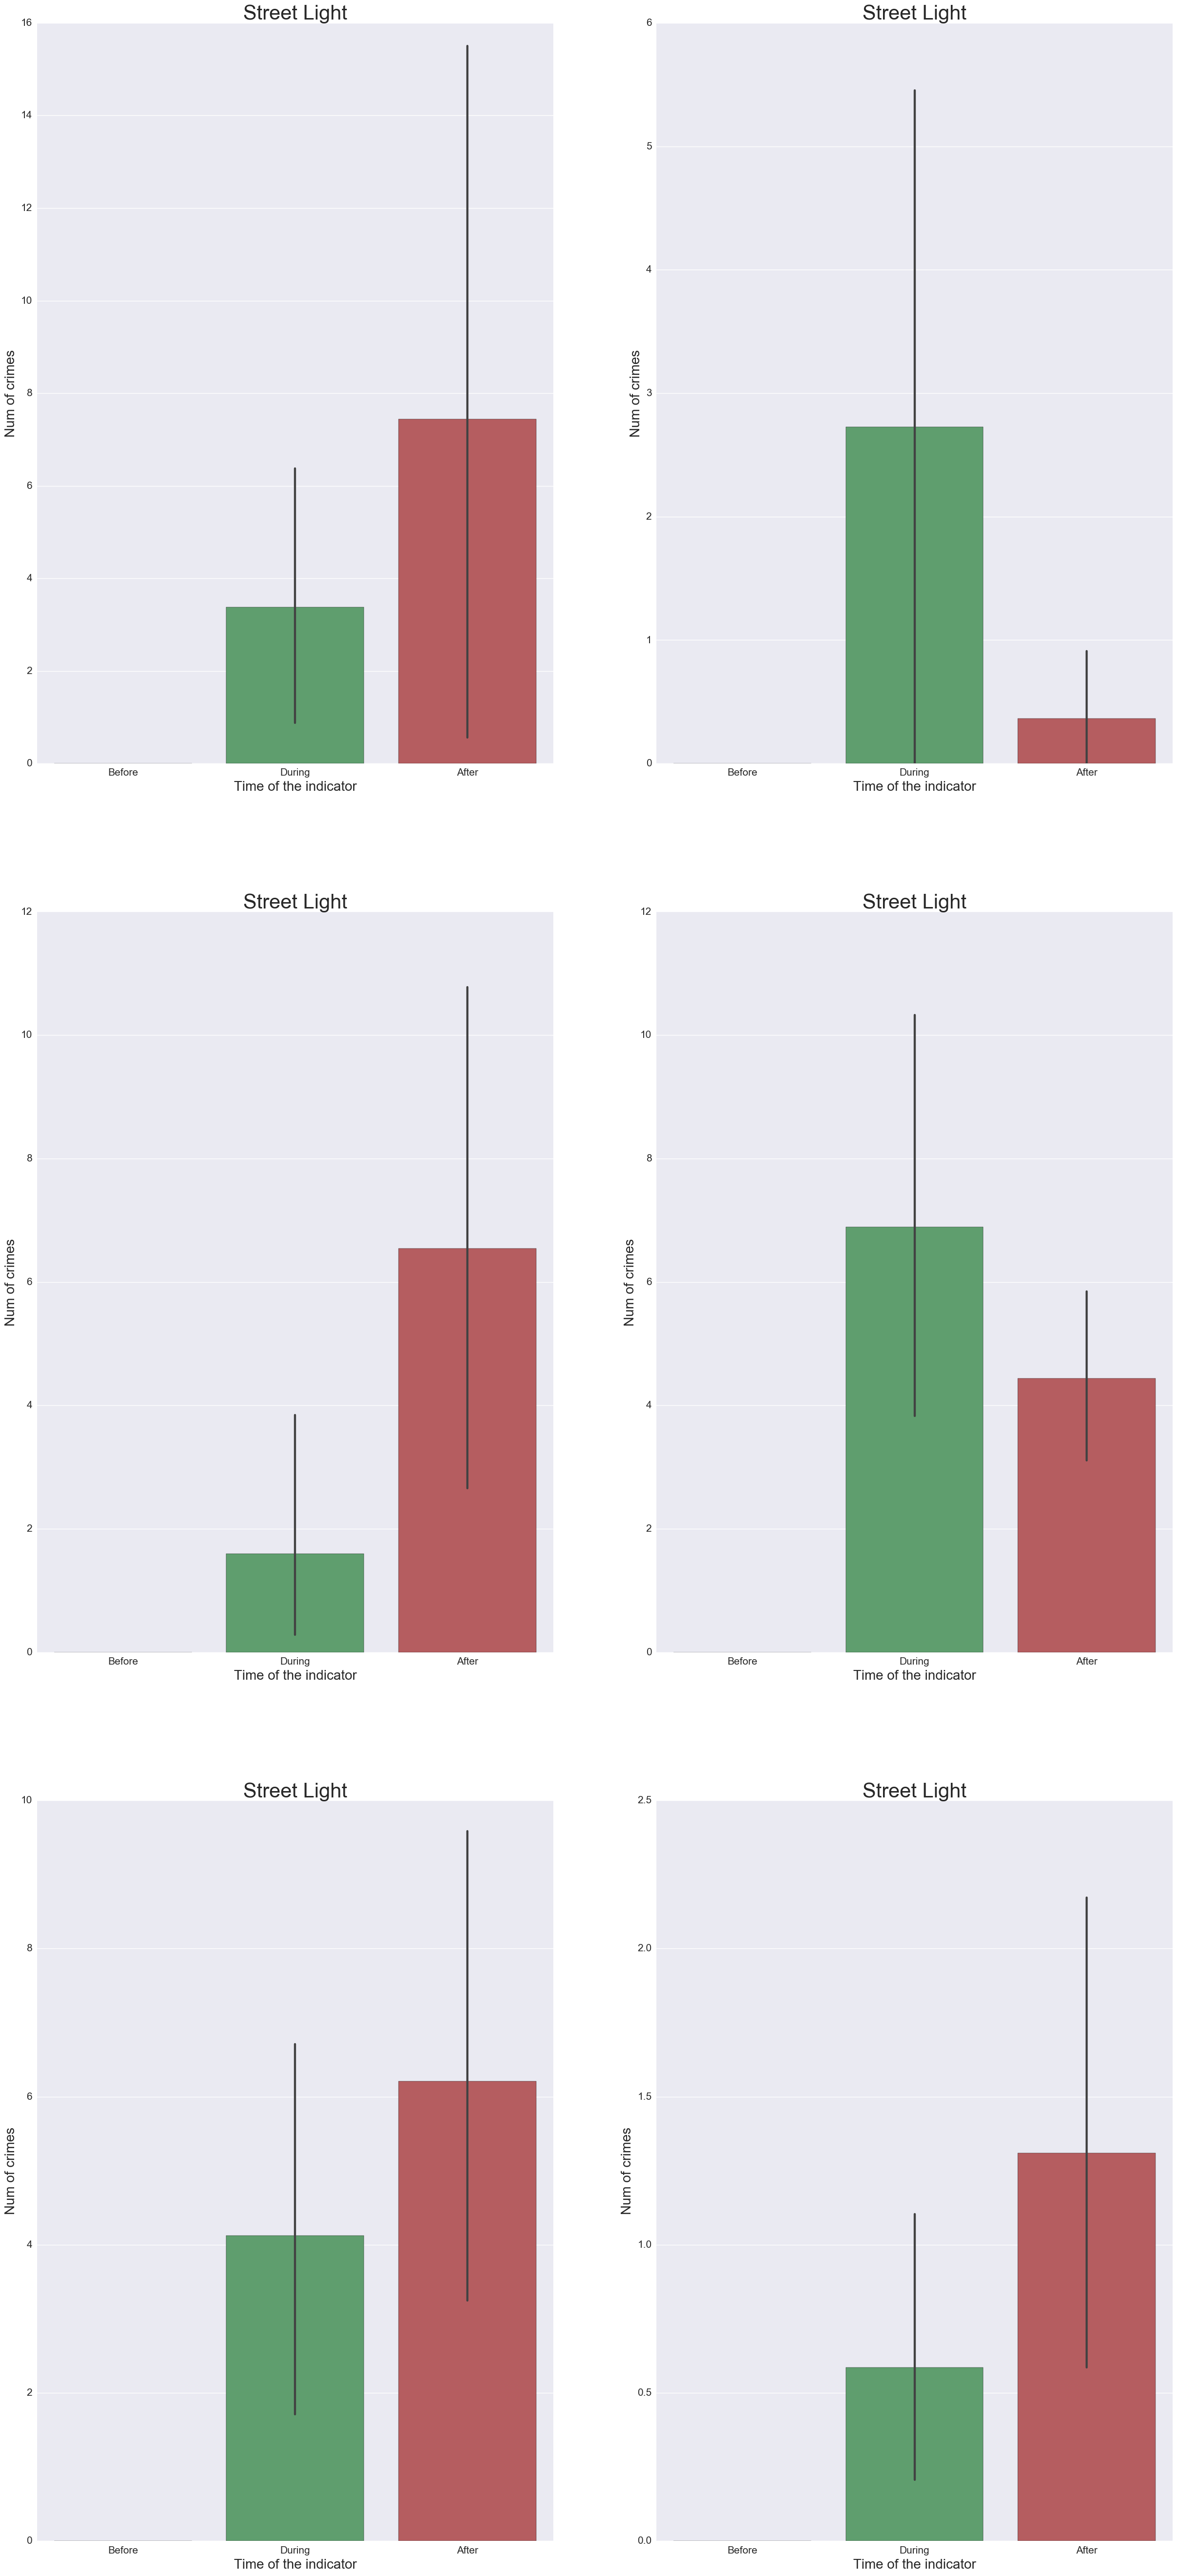

In [31]:
fig = plt.figure(dpi = 150, figsize = (30, 90))

for i in range(len(beat_list1)):
    tb = getAggCountTable(crime_data, qol_data, beat_list1[i], issue_list[4])
    ax1 = fig.add_subplot(4, 2, i + 1)
    ax1.plot =sns.barplot(x = "Time", y = "Num_Crimes", data = tb)
    plt.title(beat_list[i], fontsize = 40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(issue_list[4], fontsize = 30)
    plt.xlabel("Time of the indicator", fontsize = 20)
    plt.ylabel("Num of crimes", fontsize = 20)

fig.show()

### (6) Large Item Trash/Garbage Pickup

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


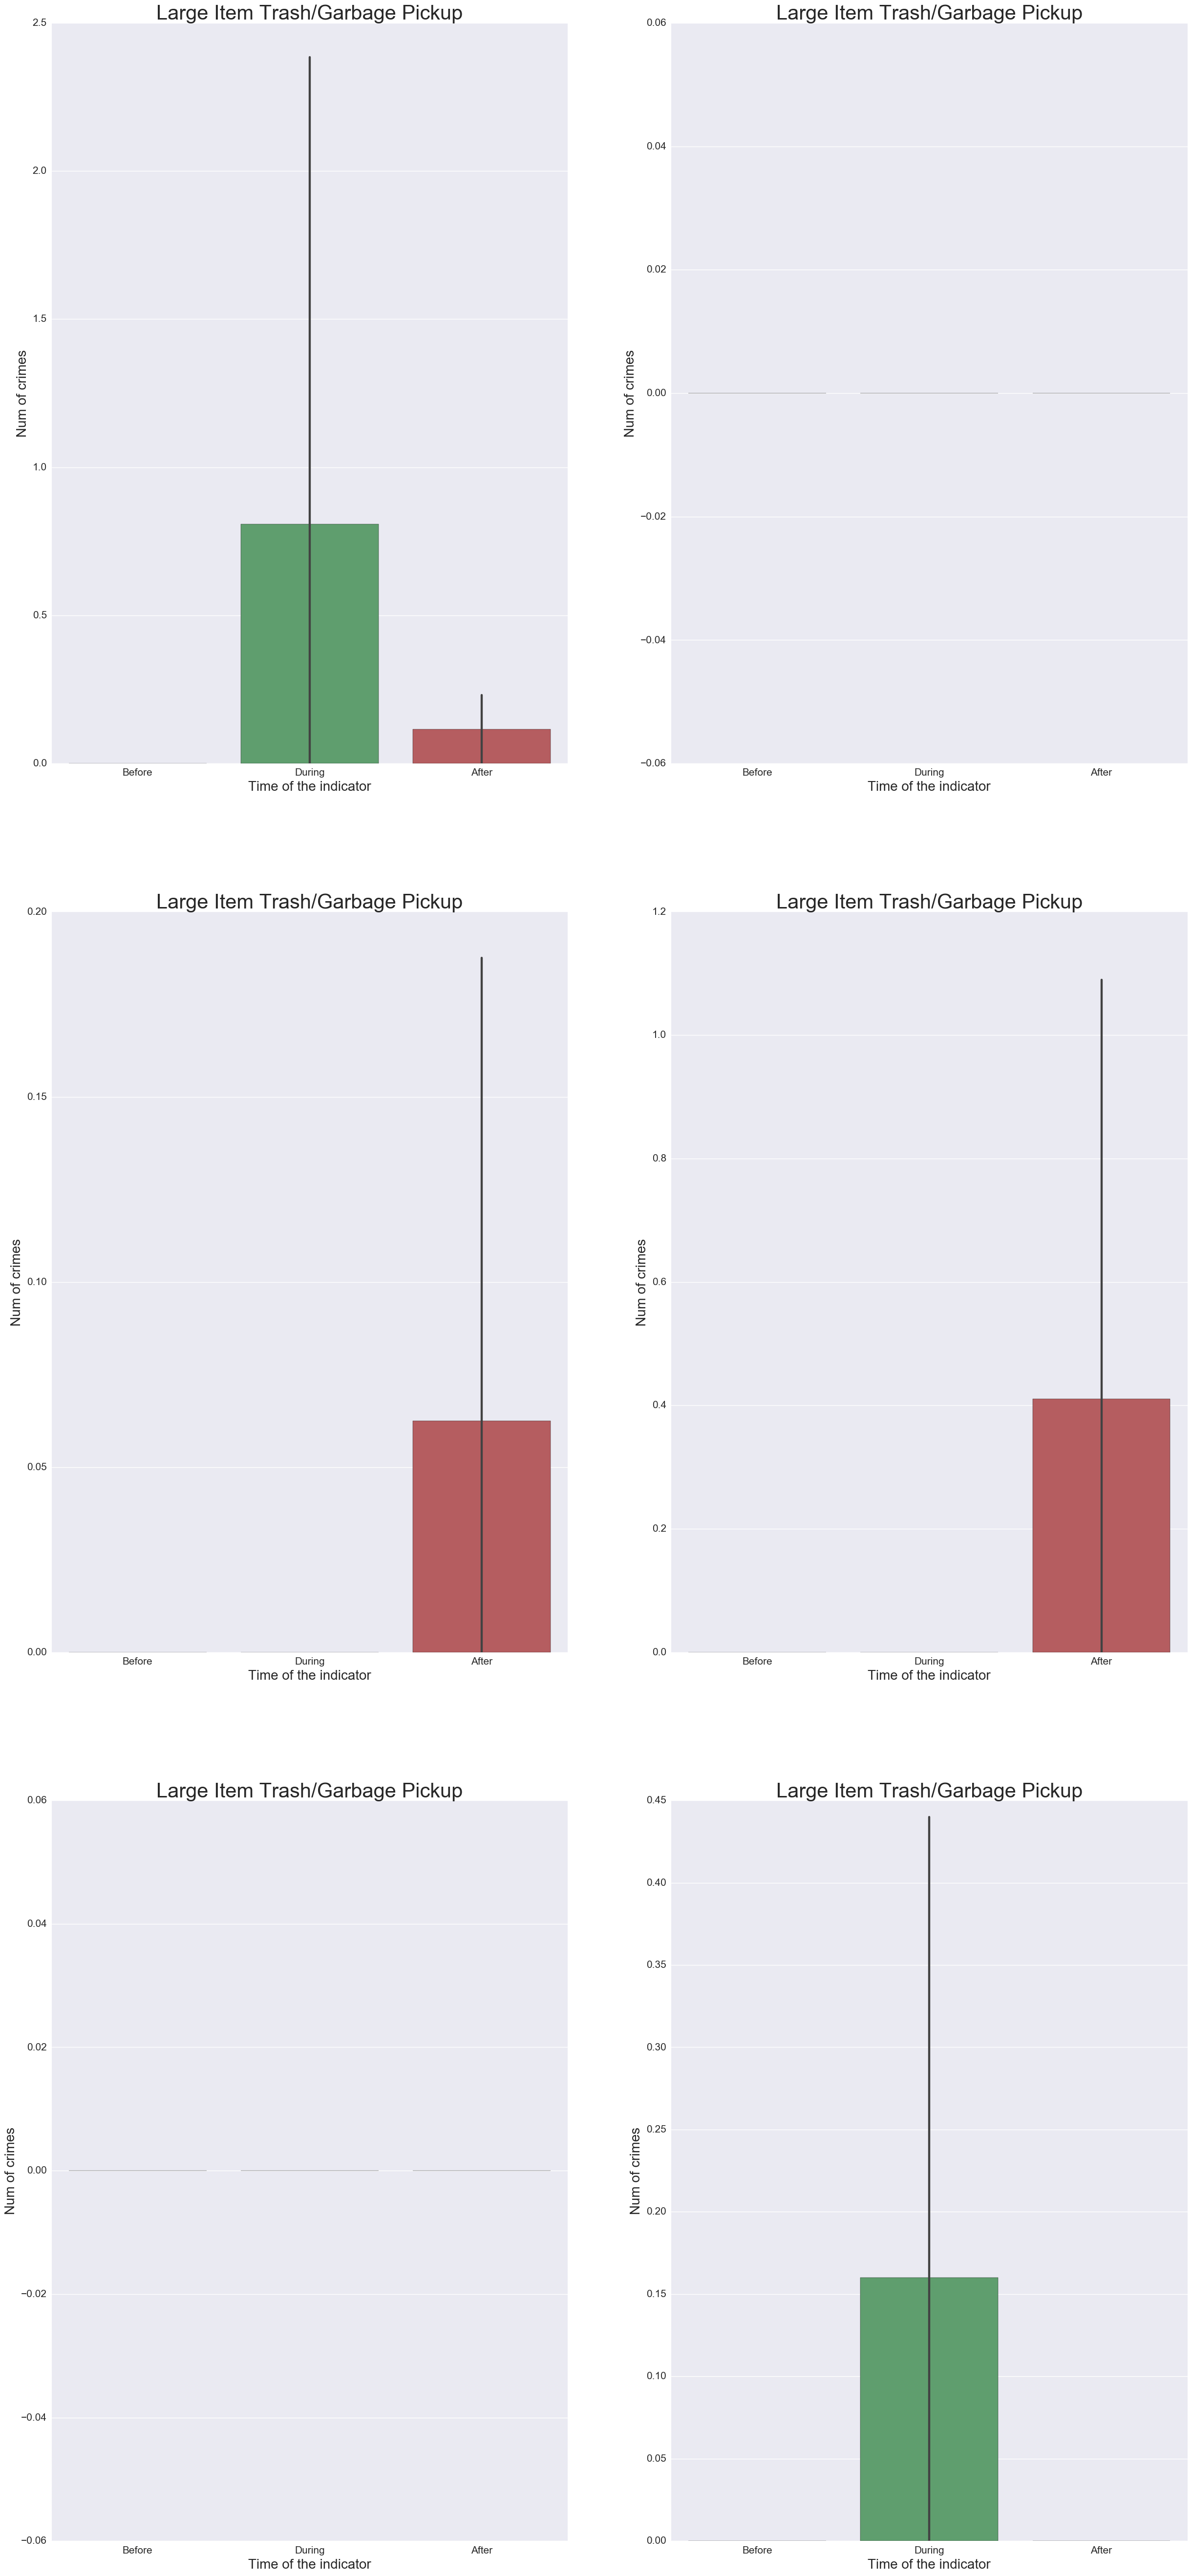

In [33]:
fig = plt.figure(dpi = 150, figsize = (30, 90))

for i in range(len(beat_list1)):
    tb = getAggCountTable(crime_data, qol_data, beat_list1[i], issue_list[5])
    ax1 = fig.add_subplot(4, 2, i + 1)
    ax1.plot =sns.barplot(x = "Time", y = "Num_Crimes", data = tb)
    plt.title(beat_list[i], fontsize = 40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(issue_list[5], fontsize = 30)
    plt.xlabel("Time of the indicator", fontsize = 20)
    plt.ylabel("Num of crimes", fontsize = 20)

fig.show()

### (7) Illegal Dumping Reporting

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


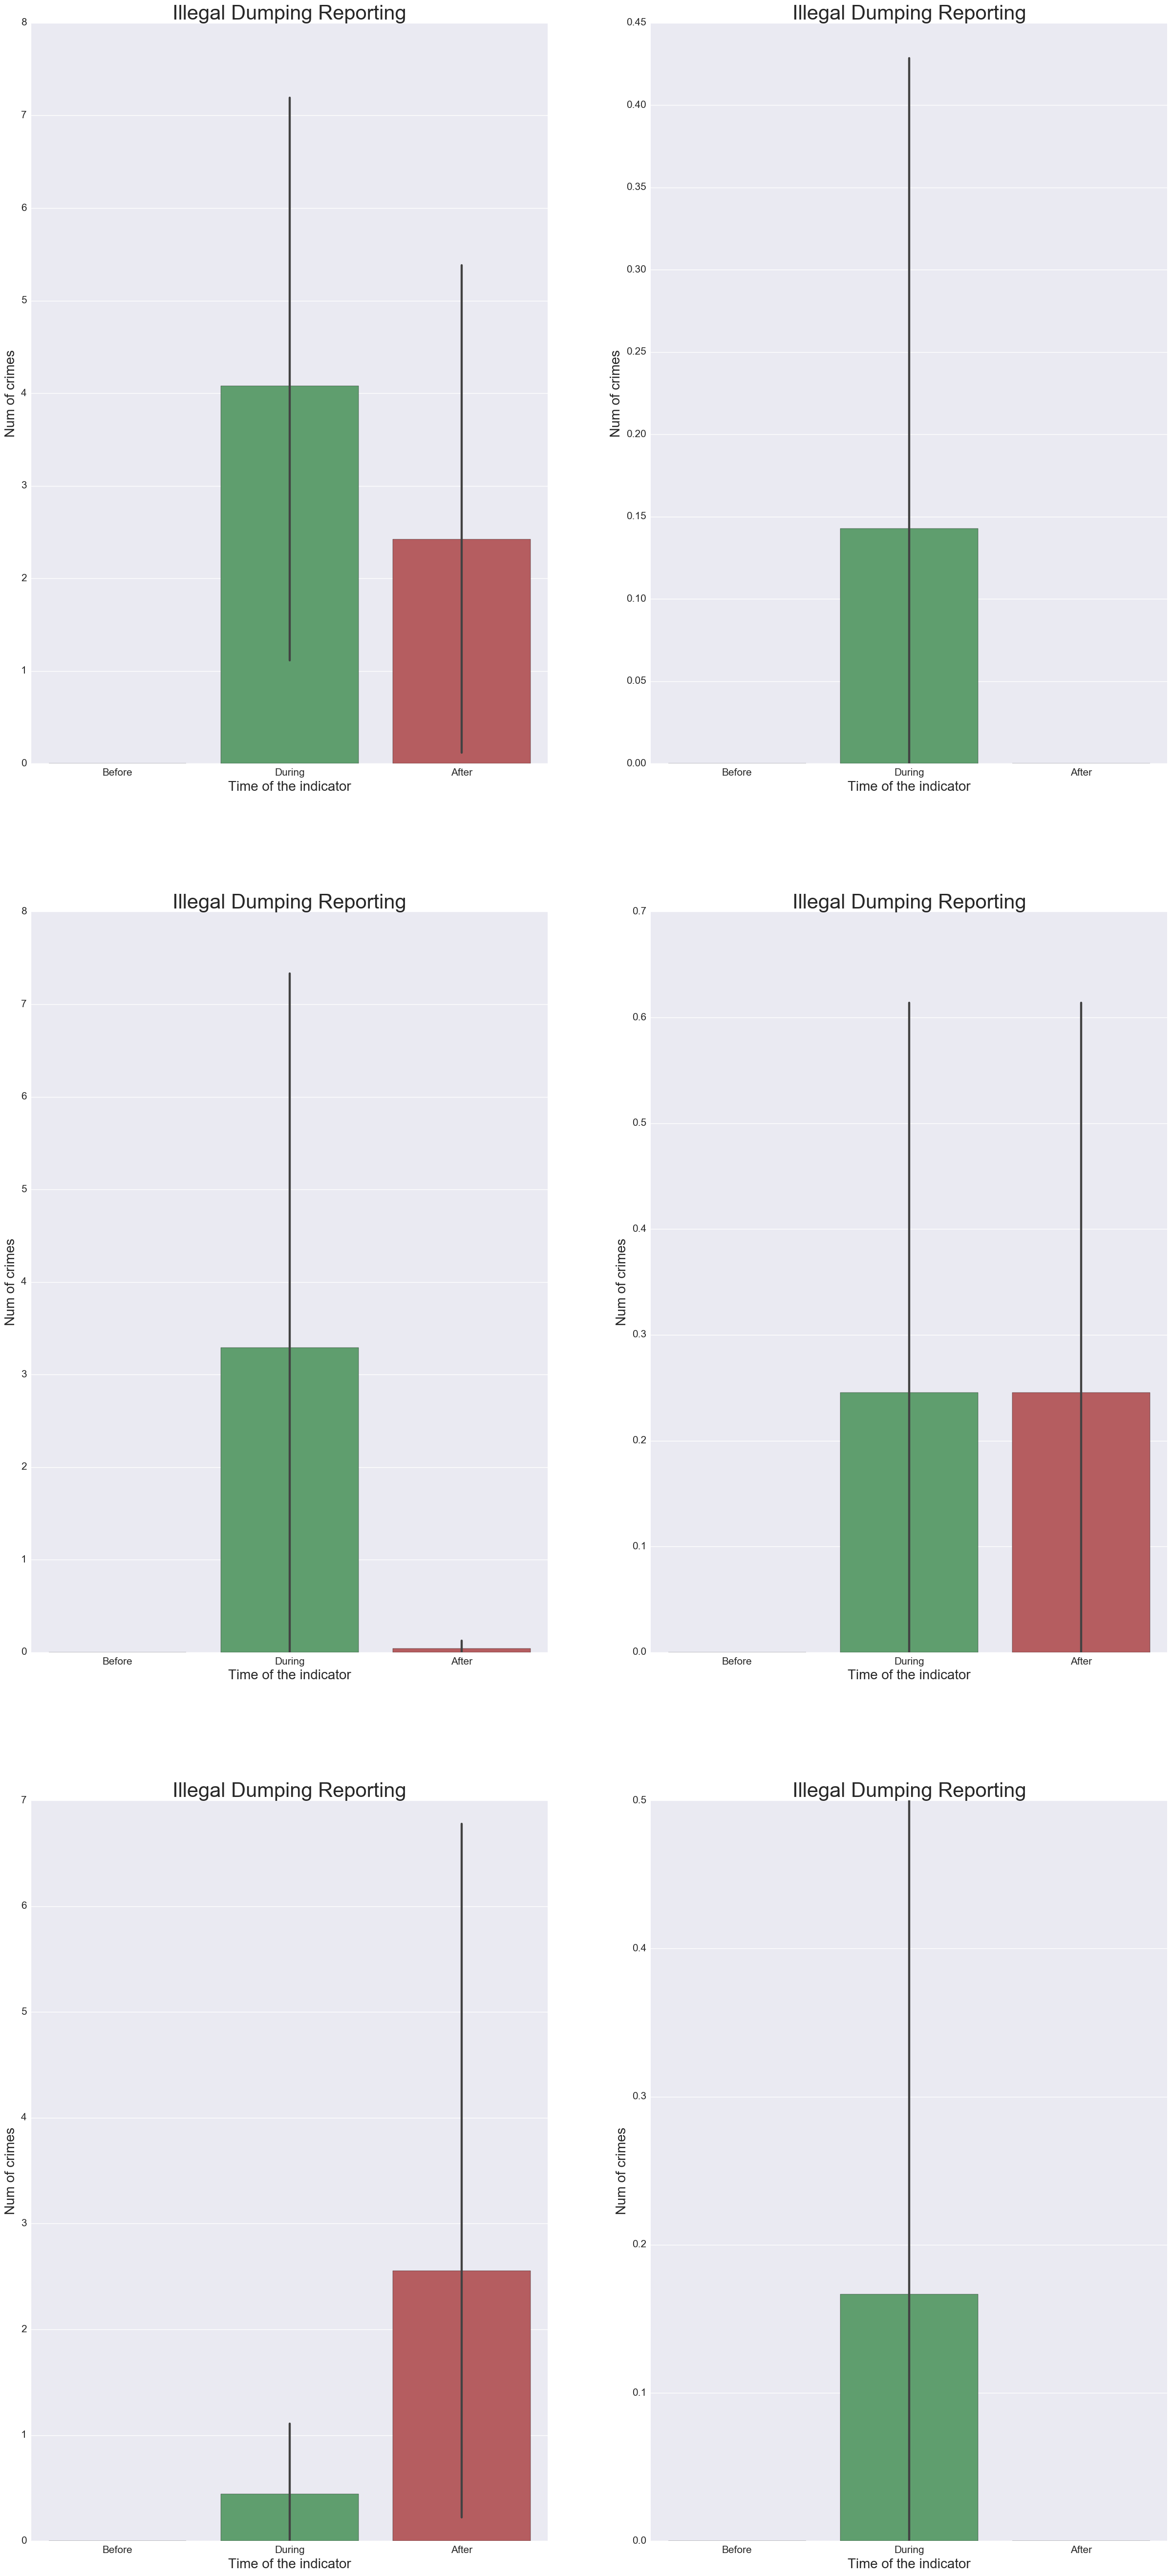

In [35]:
fig = plt.figure(dpi = 150, figsize = (30, 90))

for i in range(len(beat_list1)):
    tb = getAggCountTable(crime_data, qol_data, beat_list1[i], issue_list[6])
    ax1 = fig.add_subplot(4, 2, i + 1)
    ax1.plot =sns.barplot(x = "Time", y = "Num_Crimes", data = tb)
    plt.title(beat_list[i], fontsize = 40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(issue_list[6], fontsize = 30)
    plt.xlabel("Time of the indicator", fontsize = 20)
    plt.ylabel("Num of crimes", fontsize = 20)

fig.show()

### (8) Pothole/Roadway Surface Repair

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


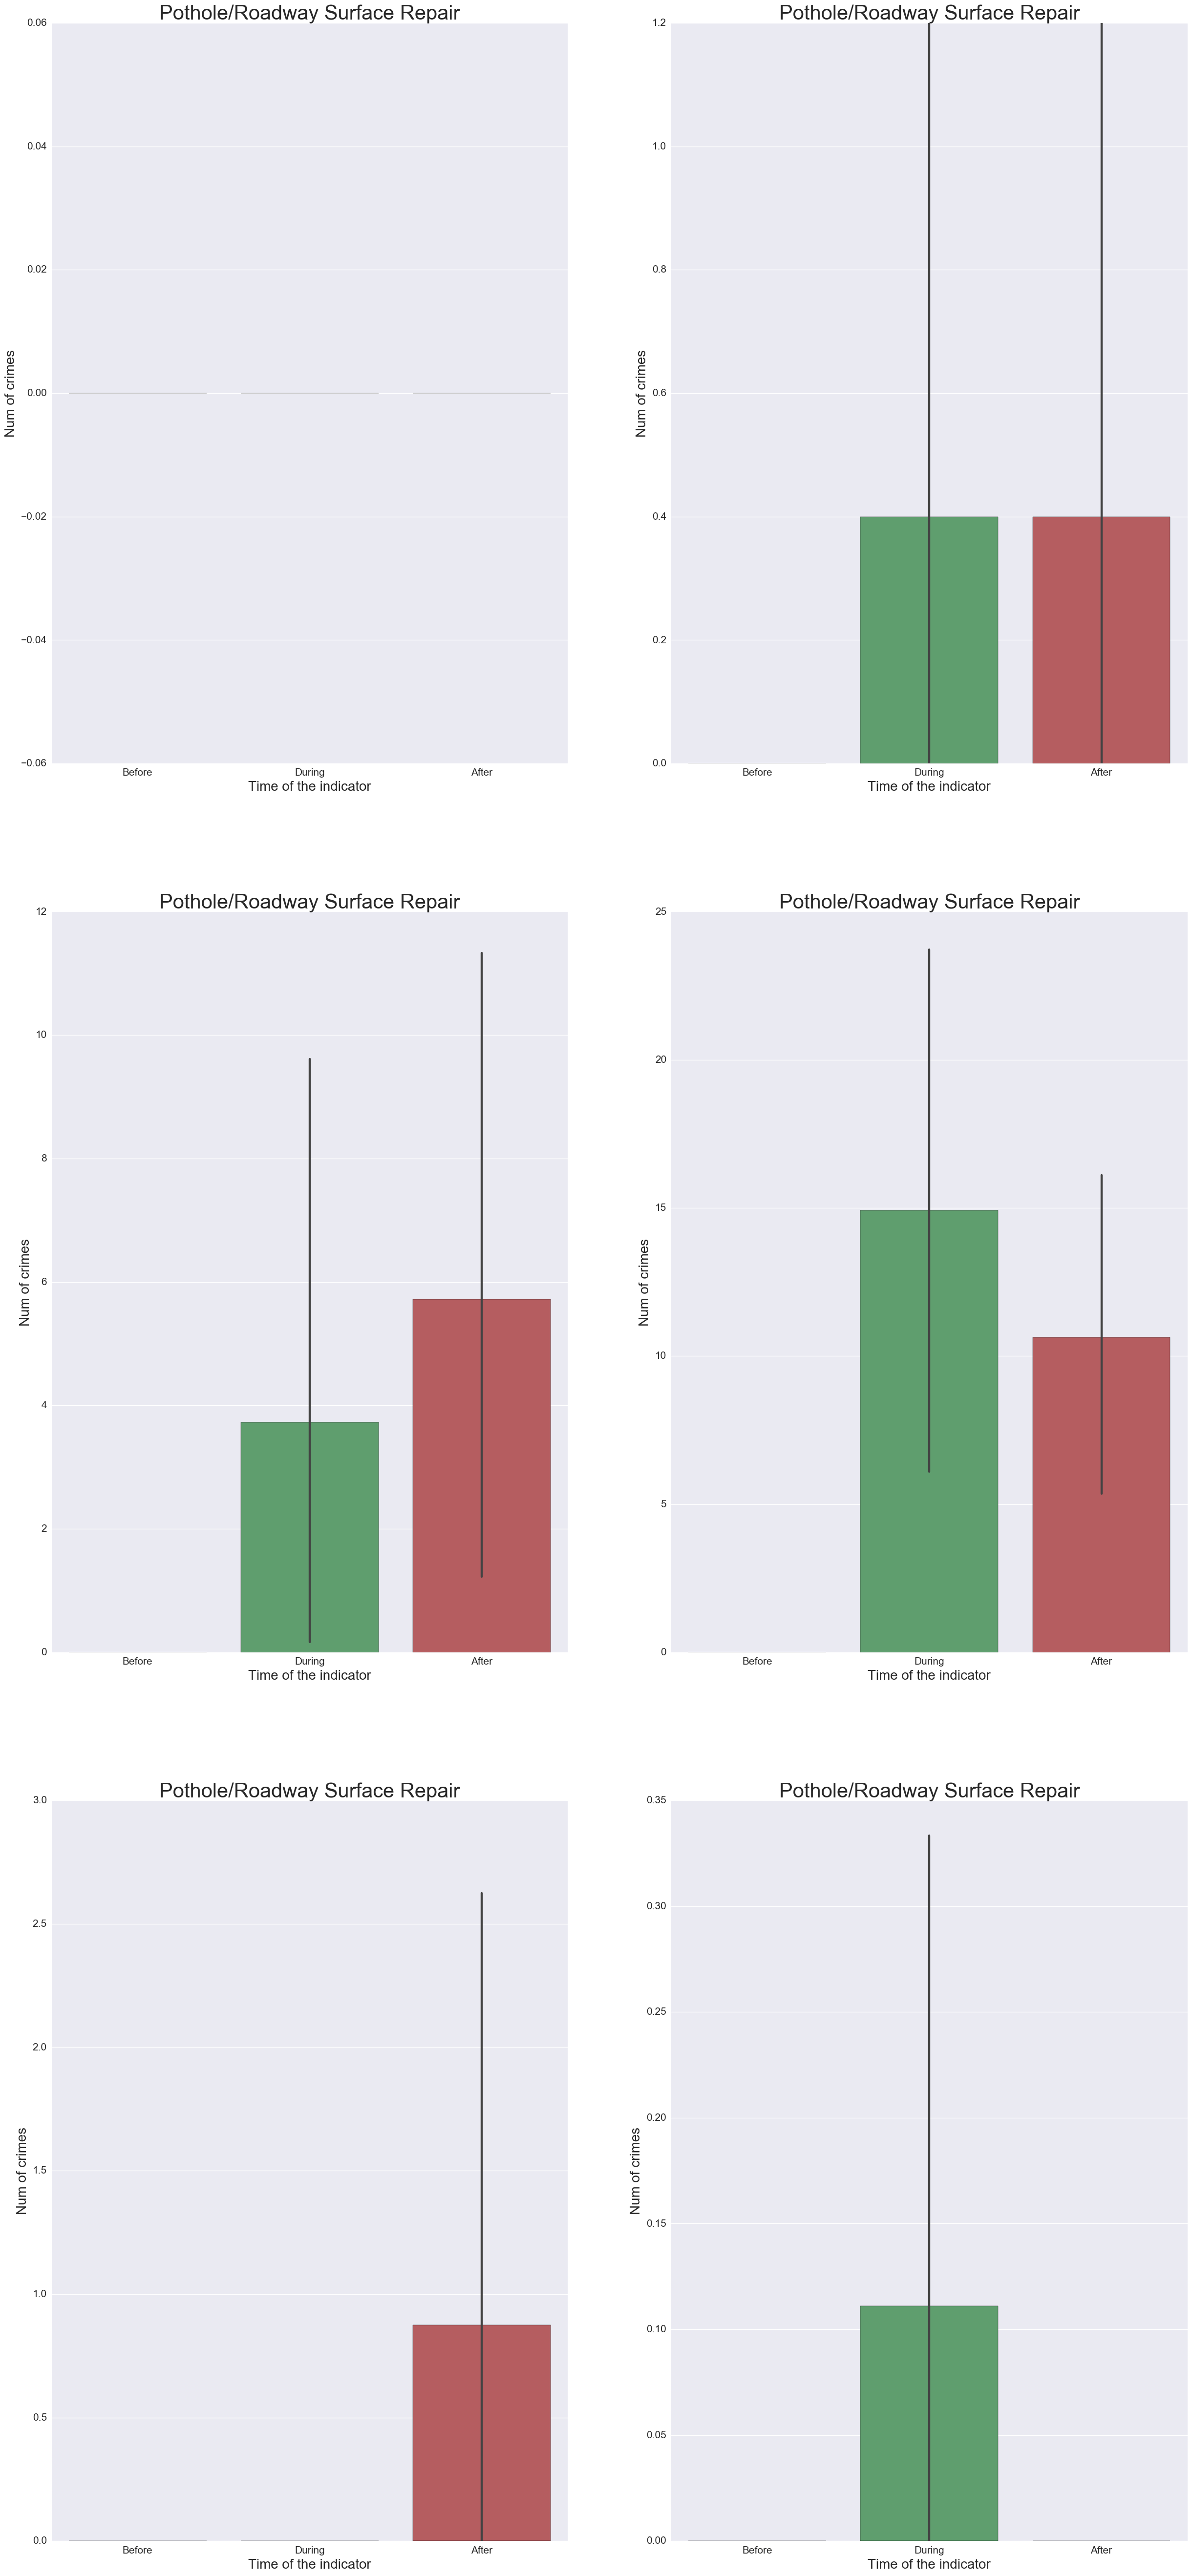

In [37]:
fig = plt.figure(dpi = 150, figsize = (30, 90))

for i in range(len(beat_list1)):
    tb = getAggCountTable(crime_data, qol_data, beat_list1[i], issue_list[7])
    ax1 = fig.add_subplot(4, 2, i + 1)
    ax1.plot =sns.barplot(x = "Time", y = "Num_Crimes", data = tb)
    plt.title(beat_list[i], fontsize = 40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(issue_list[7], fontsize = 30)
    plt.xlabel("Time of the indicator", fontsize = 20)
    plt.ylabel("Num of crimes", fontsize = 20)

fig.show()

### (9) Rodent Complaint

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


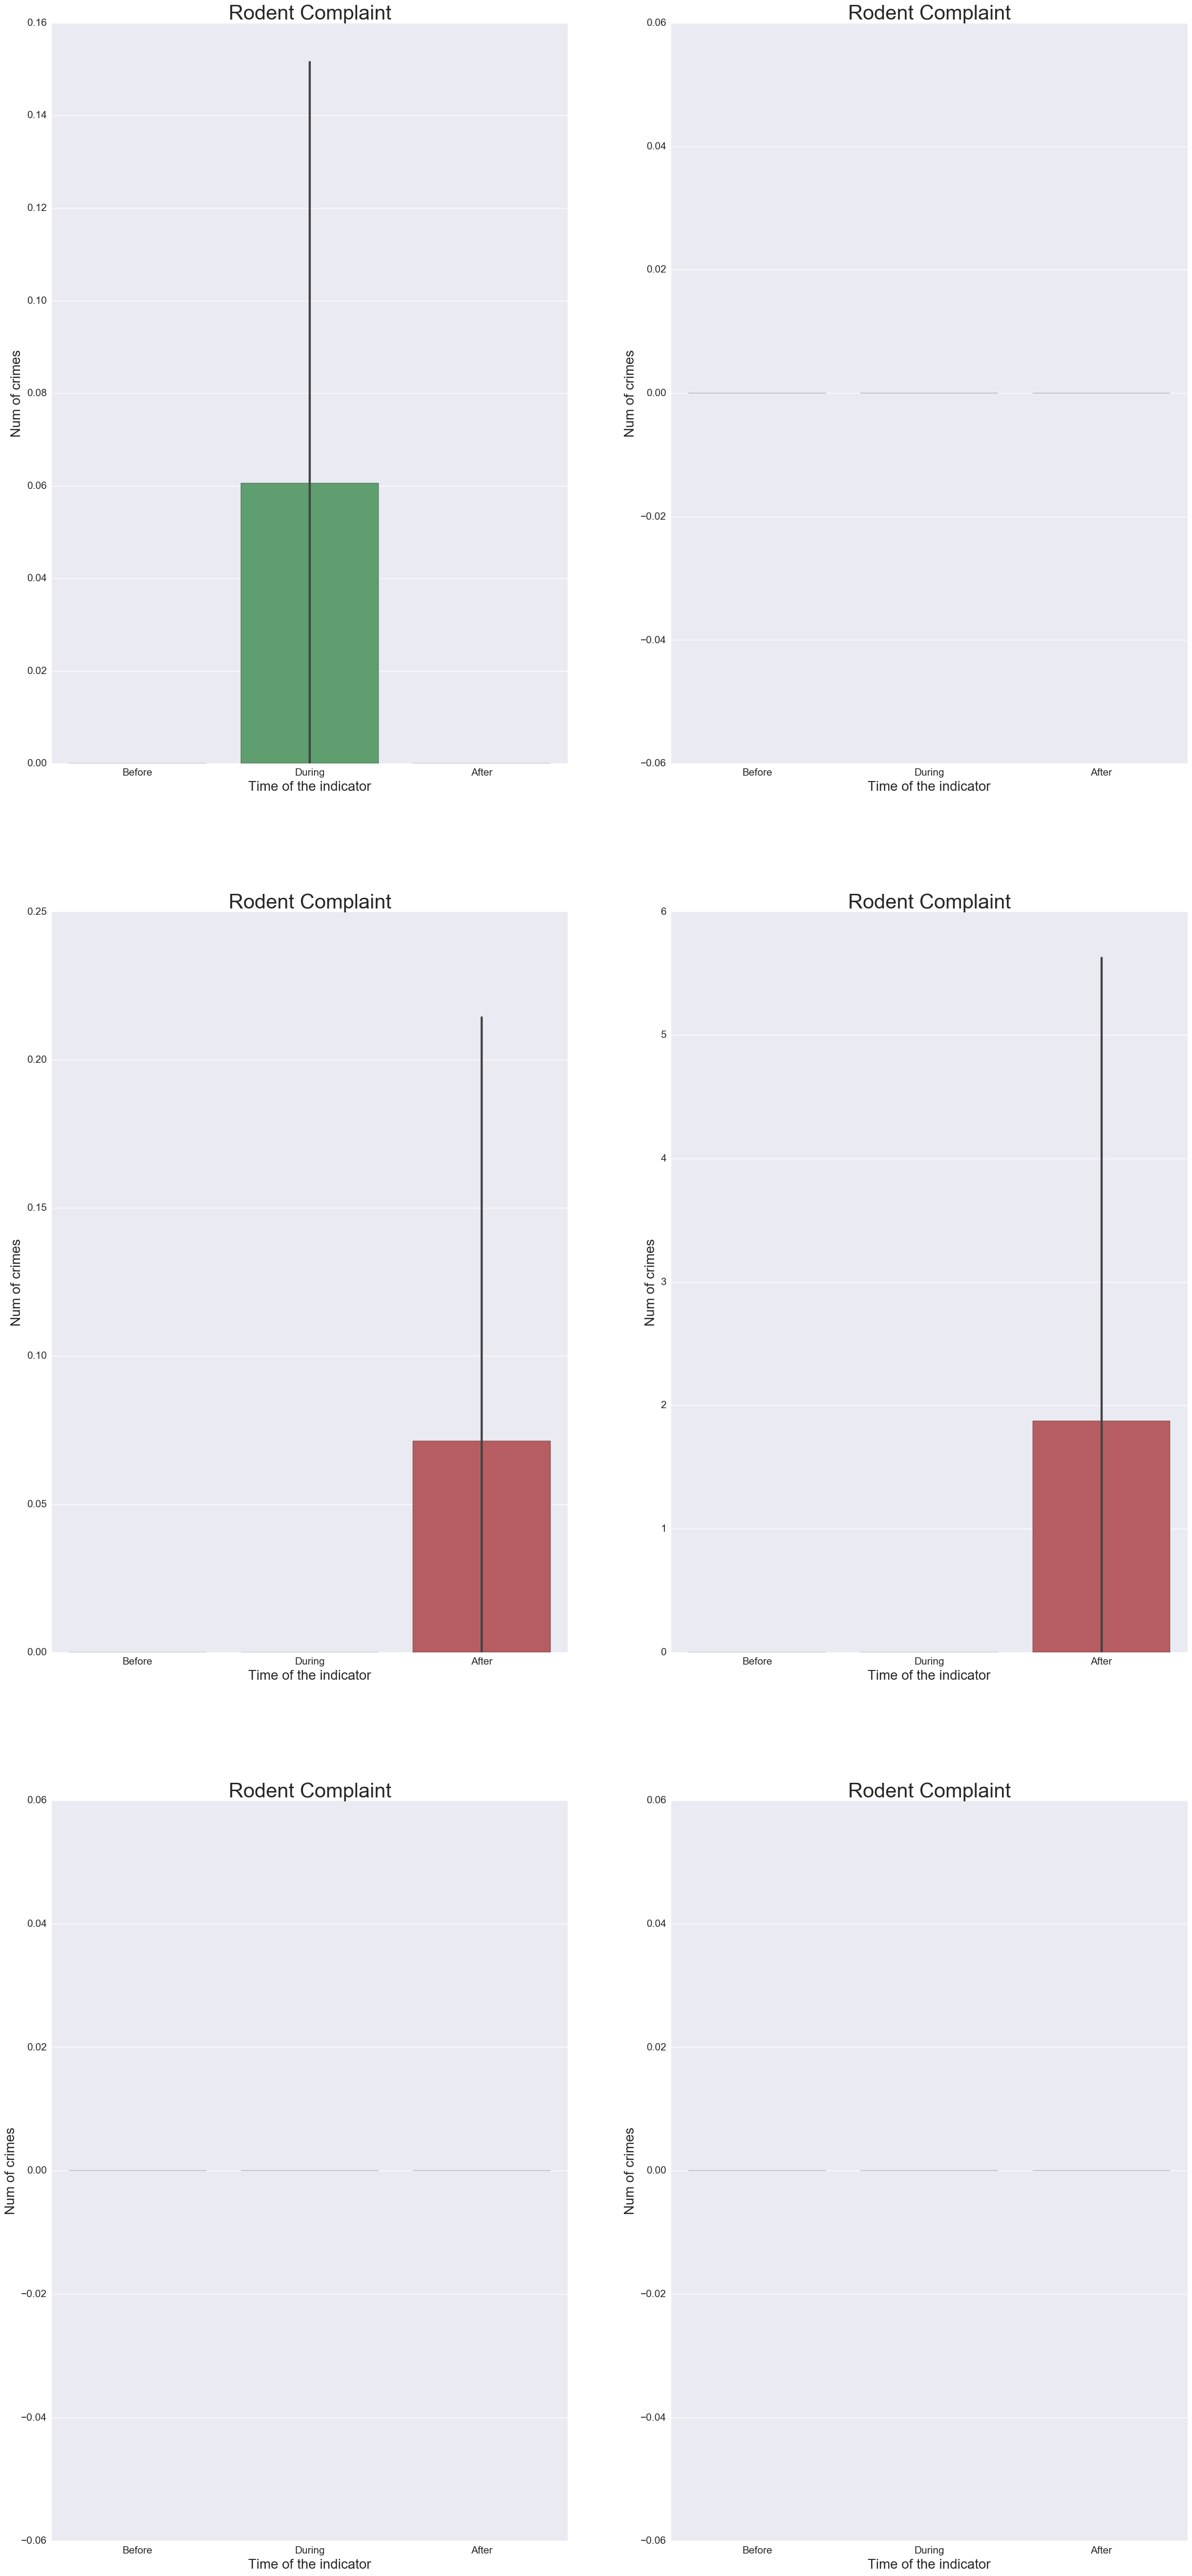

In [39]:
fig = plt.figure(dpi = 150, figsize = (30, 90))

for i in range(len(beat_list1)):
    tb = getAggCountTable(crime_data, qol_data, beat_list1[i], issue_list[8])
    ax1 = fig.add_subplot(4, 2, i + 1)
    ax1.plot =sns.barplot(x = "Time", y = "Num_Crimes", data = tb)
    plt.title(beat_list[i], fontsize = 40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(issue_list[8], fontsize = 30)
    plt.xlabel("Time of the indicator", fontsize = 20)
    plt.ylabel("Num of crimes", fontsize = 20)

fig.show()

### (10) Street Flooding/Drainage

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


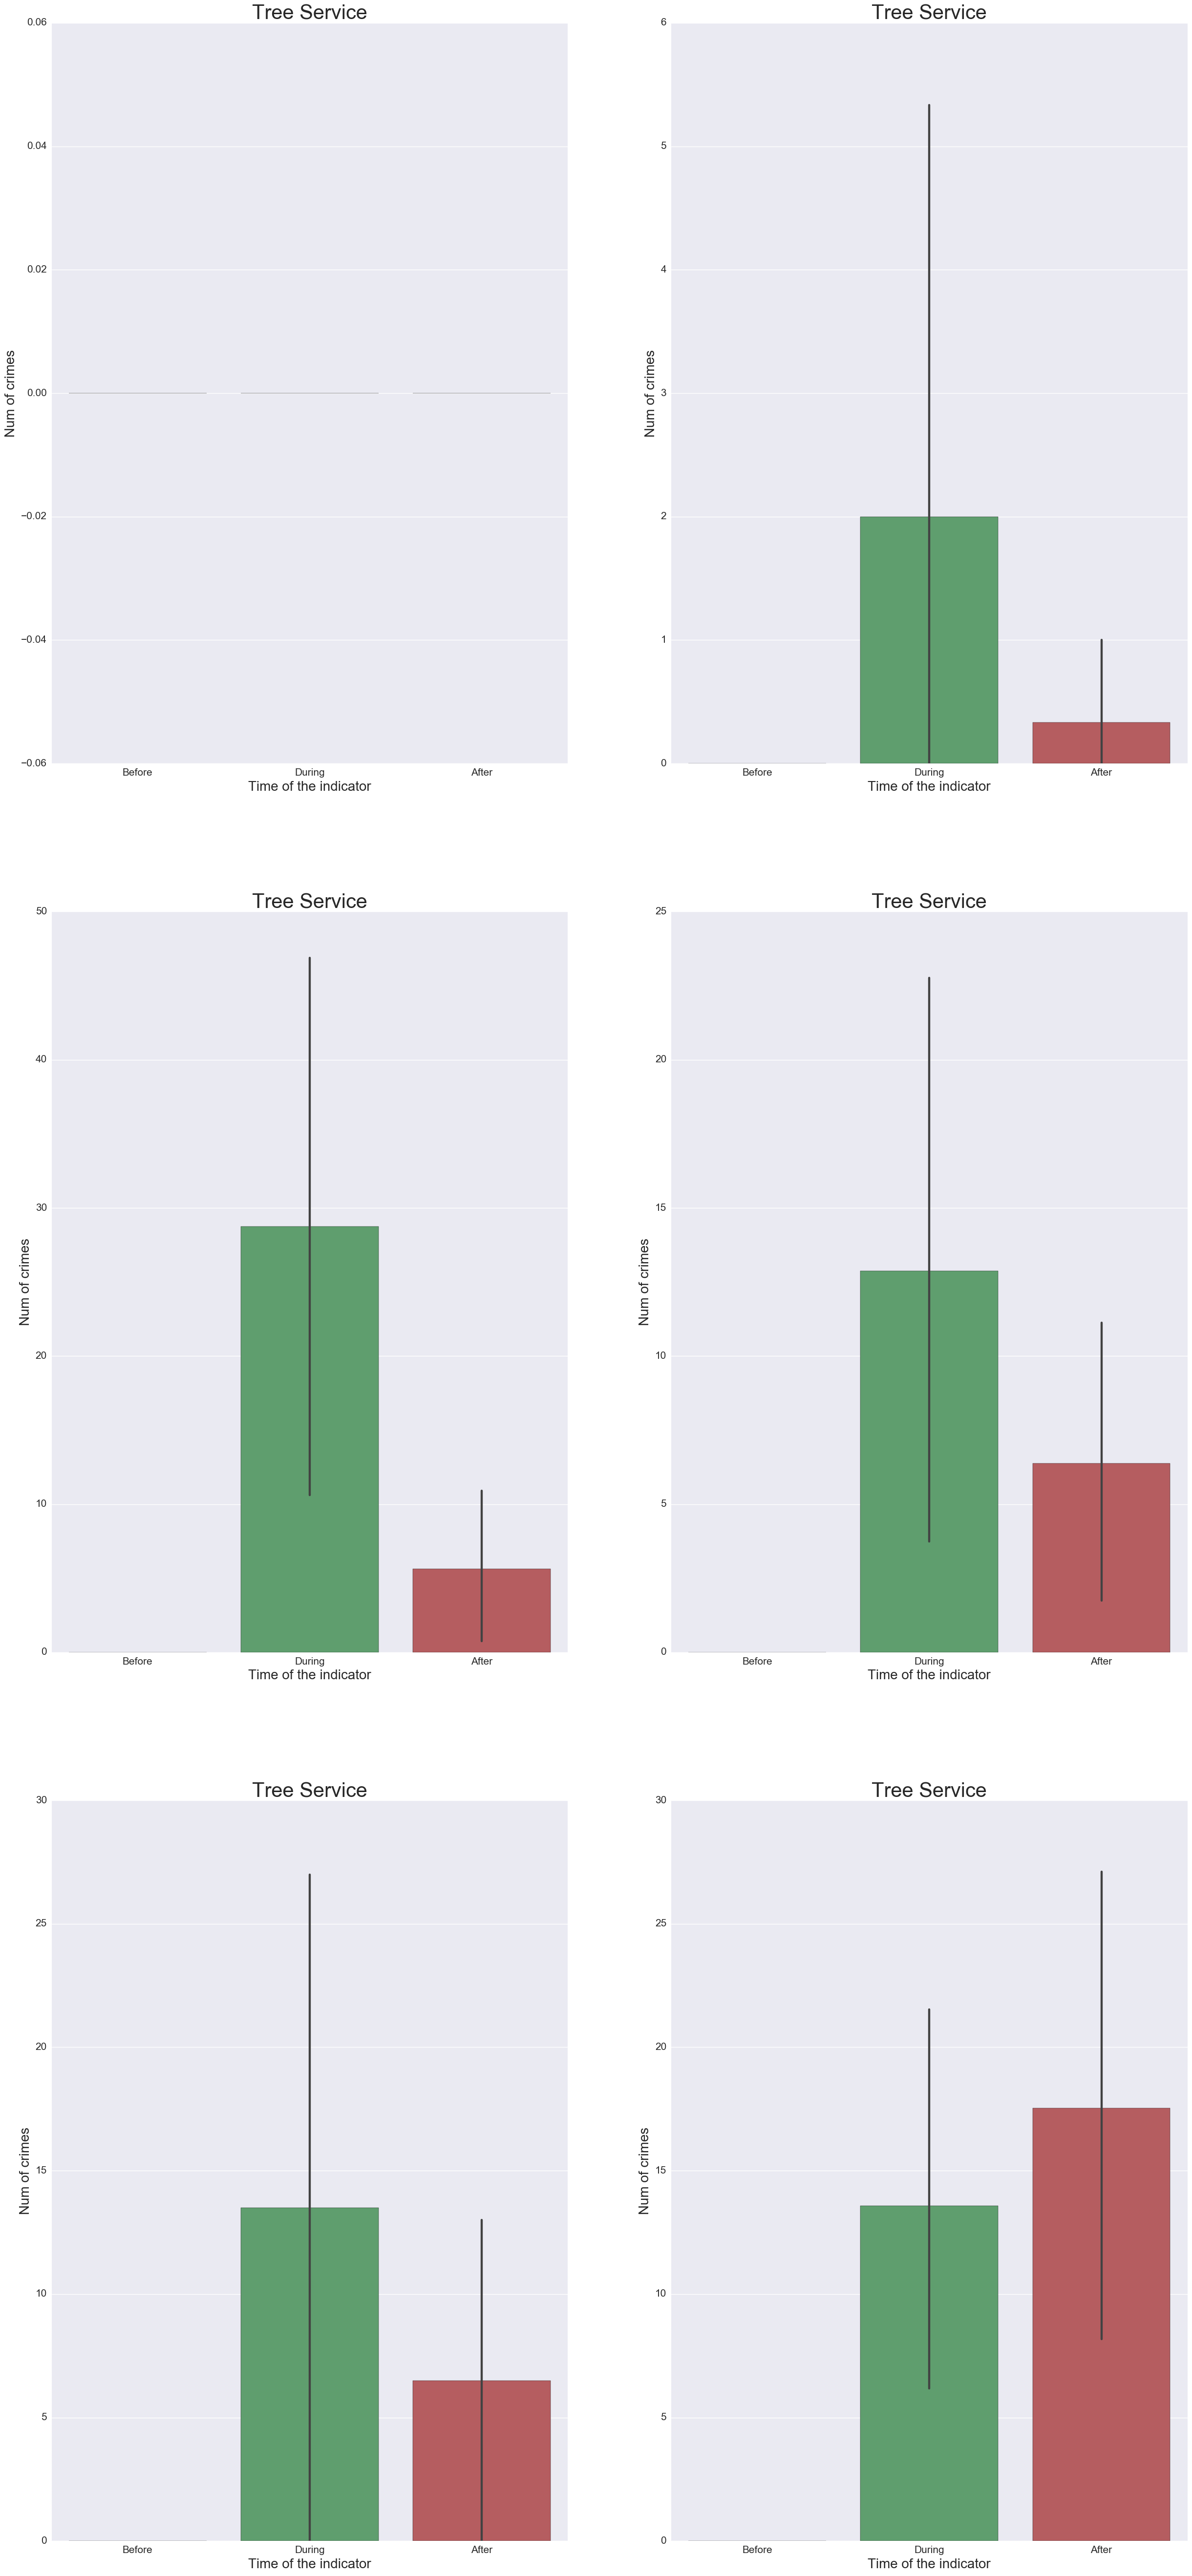

In [41]:
fig = plt.figure(dpi = 150, figsize = (30, 90))

for i in range(len(beat_list1)):
    tb = getAggCountTable(crime_data, qol_data, beat_list1[i], issue_list[9])
    ax1 = fig.add_subplot(4, 2, i + 1)
    ax1.plot =sns.barplot(x = "Time", y = "Num_Crimes", data = tb)
    plt.title(beat_list[i], fontsize = 40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(issue_list[9], fontsize = 30)
    plt.xlabel("Time of the indicator", fontsize = 20)
    plt.ylabel("Num of crimes", fontsize = 20)

fig.show()

### (11) Mosquito Control

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


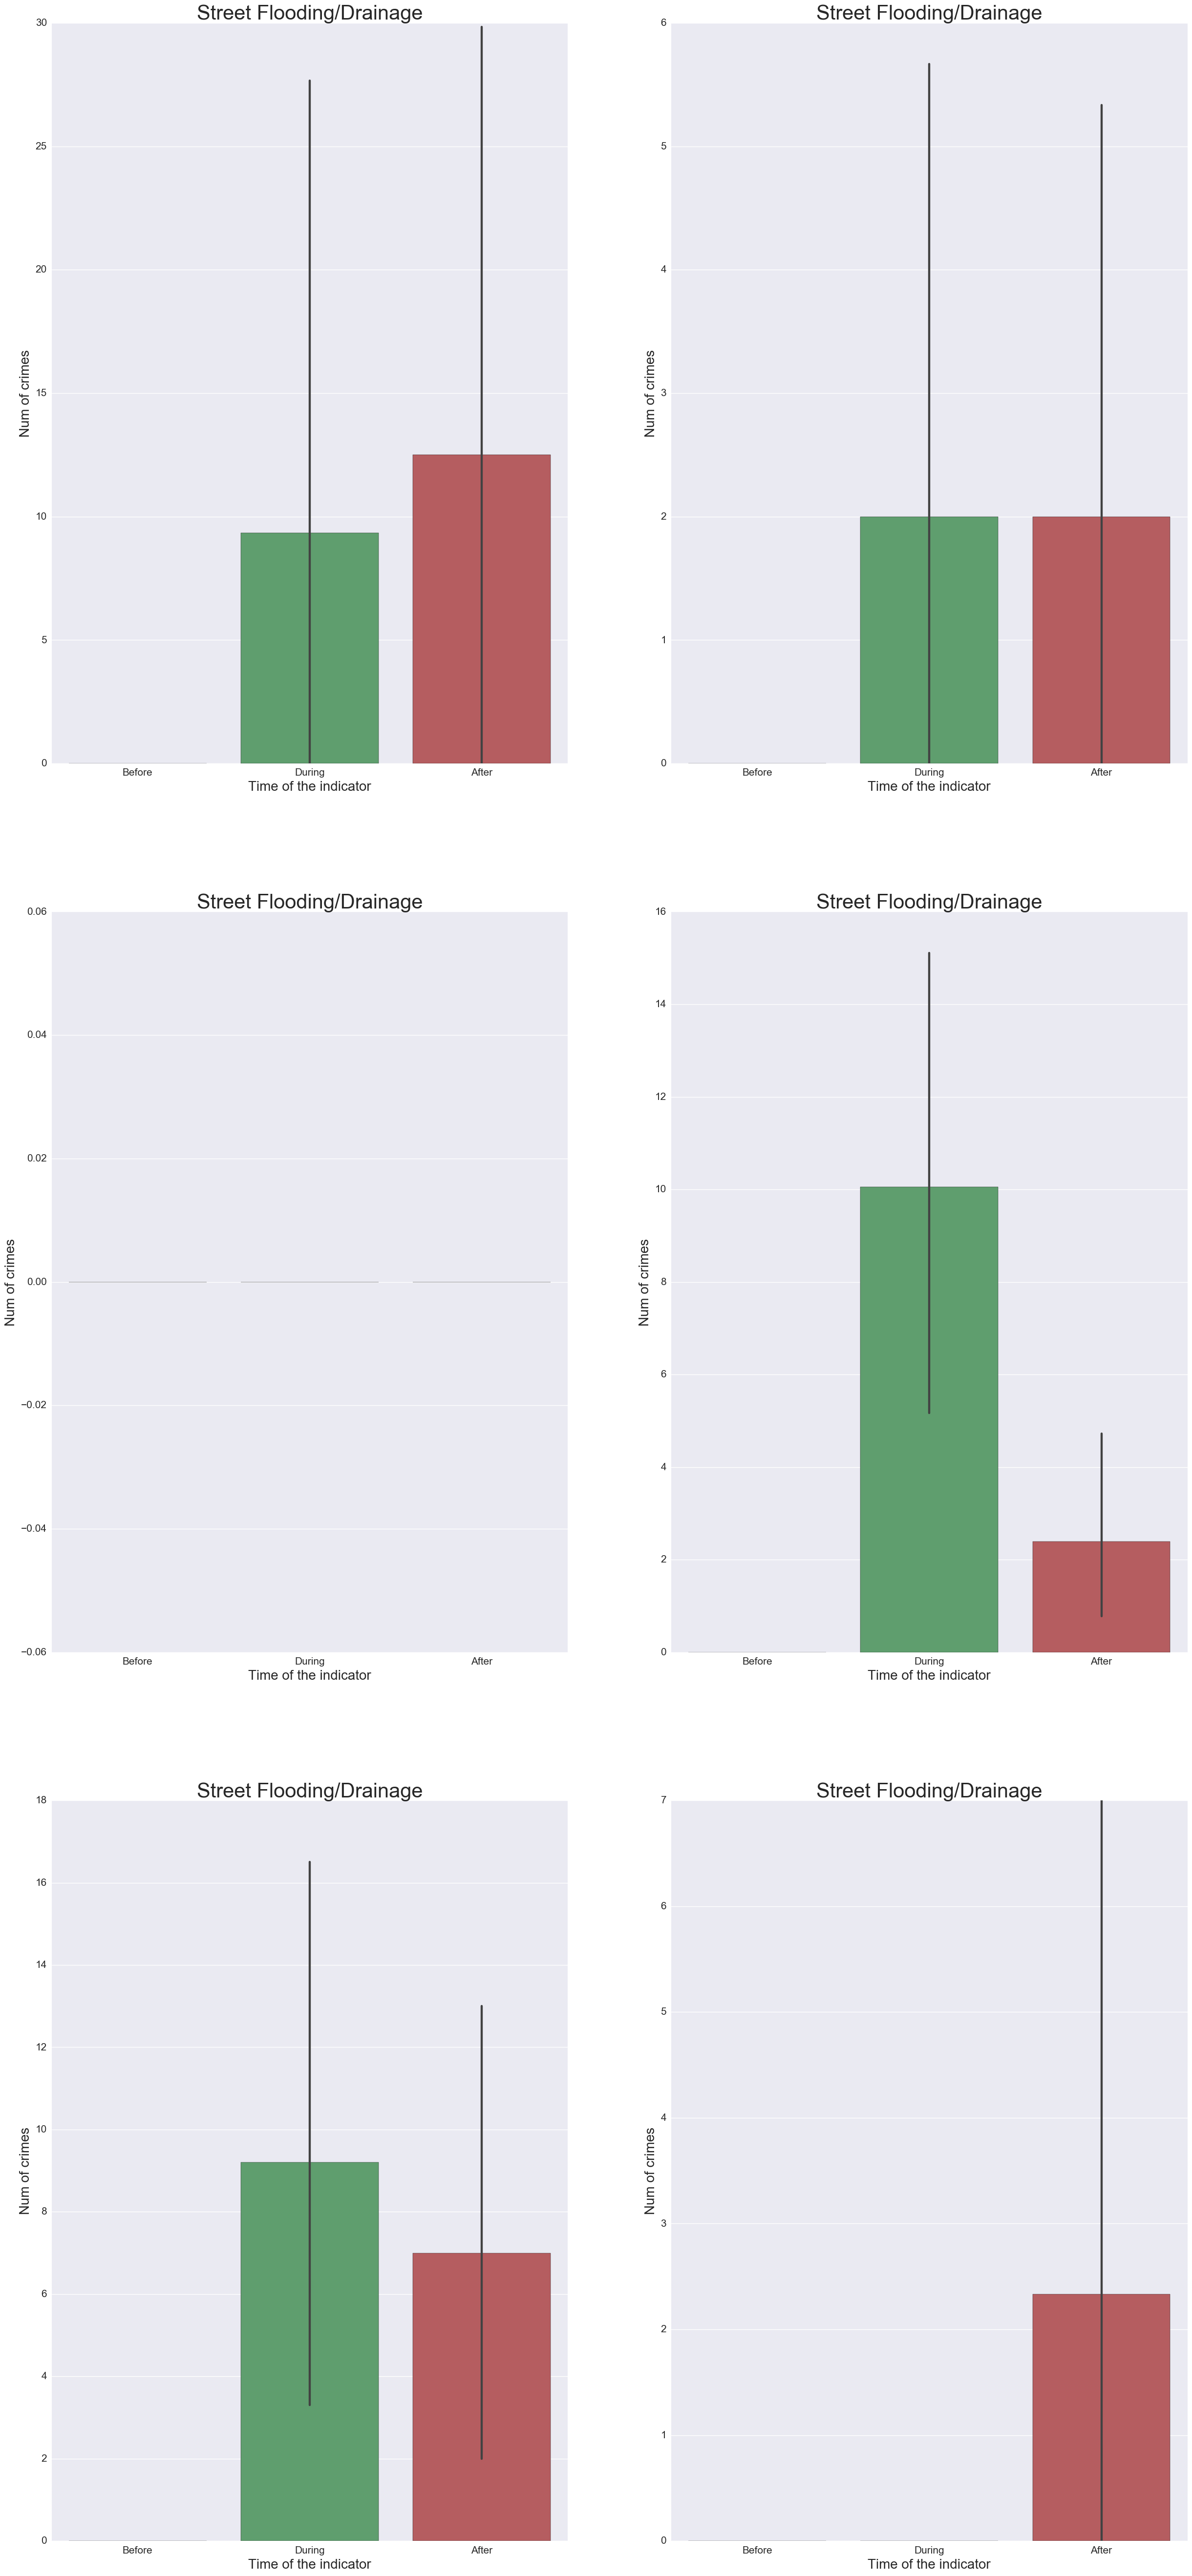

In [47]:
fig = plt.figure(dpi = 150, figsize = (30, 90))

for i in range(len(beat_list1)):
    tb = getAggCountTable(crime_data, qol_data, beat_list1[i], issue_list[10])
    ax1 = fig.add_subplot(4, 2, i + 1)
    ax1.plot =sns.barplot(x = "Time", y = "Num_Crimes", data = tb)
    plt.title(beat_list[i], fontsize = 40)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(issue_list[10], fontsize = 30)
    plt.xlabel("Time of the indicator", fontsize = 20)
    plt.ylabel("Num of crimes", fontsize = 20)

fig.show()